In [1]:
## 1. Business Understanding

In [2]:
# DSO1: predire la qualite de vin selon les caracteristiques chimiques 
# DSO2 :classifier les groupes de vin selon des carateristique similaire (segmenter les groupes en des groupes similaires)
# PCA est une methode descriptive on n'utilise pas dans prediction 

# 2. Compréhension des Données

Cette section explore le jeu de données de qualité des vins à travers diverses visualisations, statistiques descriptives, et analyses exploratoires. Nous examinerons systématiquement :

- **Structure et distribution** des caractéristiques physico-chimiques
- **Valeurs manquantes** et leur impact potentiel
- **Valeurs dupliquées** qui pourraient biaiser l'analyse
- **Détection d'outliers** via méthodes statistiques (boxplots, z-scores)
- **Corrélations entre variables** pour comprendre les relations sous-jacentes

L'objectif est d'obtenir une compréhension approfondie des données avant de procéder à la modélisation.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve, confusion_matrix, mean_squared_error,
                             mean_absolute_error, r2_score, silhouette_score,
                             davies_bouldin_score, calinski_harabasz_score)
from IPython.display import display
import joblib

# Configuration des styles pour une meilleure visualisation
sns.set_style('whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
%matplotlib inline

# Suppression des warnings pour un affichage plus propre
import warnings
warnings.filterwarnings('ignore')

In [4]:
#Load Data
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
df = pd.read_csv(url, sep=';')
# Display basic information
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
df.info()
print("\nFirst 5 Rows:")
display(df.head())

df['quality_label'] = (df['quality'] >= 7).astype(int)  # 1 -> good, 0 -> not good
print('Counts (good=1):')
print(df['quality_label'].value_counts())

Dataset Shape: (1599, 12)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB

First 5 Rows:


fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

Counts (good=1):
quality_label
0    1382
1     217
Name: count, dtype: int64


In [5]:
#Summary Statistics
# Summary statistics for numerical columns
print("Numerical Columns Summary:")
display(df.describe())

# Check for categorical columns before generating summary
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
if len(categorical_cols) > 0:
    print("\nCategorical Columns Summary:")
    display(df.describe(include=['object', 'category']))
else:
    print("\nNo categorical columns found in the dataset.")

Numerical Columns Summary:


fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000             1.000000              6.000000     0.990070   
25%       0.070000             7.000000             22.000000     0.995600   
50%       0.079000            14.000000             38.000000     0.996750   
75%       0.090000            21.000000             62.000000     0.997835   
max       0.611000            72.000000            289.000000     1.003690   

                pH    sulphates      alcohol      quality  quality_label  
count  1599.000000  1599.000000  1599.000000  1599.000000    1599.000000  
mean      3.311113     0.658149    10.422983     5.636023       0.135710  
std       0.154386     0.169507     1.065668     0.807569       0.342587  
min       2.740000     0.330000     8.400000     3.000000       0.000000  
25%       3.210000     0.550000     9.500000     5.000000       0.000000  
50%       3.310000     0.620000    10.200000     6.000000       0.000000  
75%       3.400000     0.730000    11.100000     6.000000       0.000000  
max       4.010000     2.000000    14.900000     8.000000       1.000000


No categorical columns found in the dataset.


Analyse des valeurs manquantes:


Nombre de valeurs manquantes  Pourcentage (%)
fixed acidity                                    0              0.0
volatile acidity                                 0              0.0
citric acid                                      0              0.0
residual sugar                                   0              0.0
chlorides                                        0              0.0
free sulfur dioxide                              0              0.0
total sulfur dioxide                             0              0.0
density                                          0              0.0
pH                                               0              0.0
sulphates                                        0              0.0
alcohol                                          0              0.0
quality                                          0              0.0
quality_label                                    0              0.0


✓ Aucune valeur manquante trouvée dans le dataset!

Nombre de lignes dupliquées: 240

Lignes dupliquées:


fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
4               7.4             0.700         0.00            1.90      0.076   
11              7.5             0.500         0.36            6.10      0.071   
27              7.9             0.430         0.21            1.60      0.106   
40              7.3             0.450         0.36            5.90      0.074   
65              7.2             0.725         0.05            4.65      0.086   
...             ...               ...          ...             ...        ...   
1563            7.2             0.695         0.13            2.00      0.076   
1564            7.2             0.695         0.13            2.00      0.076   
1567            7.2             0.695         0.13            2.00      0.076   
1581            6.2             0.560         0.09            1.70      0.053   
1596            6.3             0.510         0.13            2.30      0.076   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
4                    11.0                  34.0  0.99780  3.51       0.56   
11                   17.0                 102.0  0.99780  3.35       0.80   
27                   10.0                  37.0  0.99660  3.17       0.91   
40                   12.0                  87.0  0.99780  3.33       0.83   
65                    4.0                  11.0  0.99620  3.41       0.39   
...                   ...                   ...      ...   ...        ...   
1563                 12.0                  20.0  0.99546  3.29       0.54   
1564                 12.0                  20.0  0.99546  3.29       0.54   
1567                 12.0                  20.0  0.99546  3.29       0.54   
1581                 24.0                  32.0  0.99402  3.54       0.60   
1596                 29.0                  40.0  0.99574  3.42       0.75   

      alcohol  quality  quality_label  
4         9.4        5              0  
11       10.5        5              0  
27        9.5        5              0  
40       10.5        5              0  
65       10.9        5              0  
...       ...      ...            ...  
1563     10.1        5              0  
1564     10.1        5              0  
1567     10.1        5              0  
1581     11.3        5              0  
1596     11.0        6              0  

[240 rows x 13 columns]

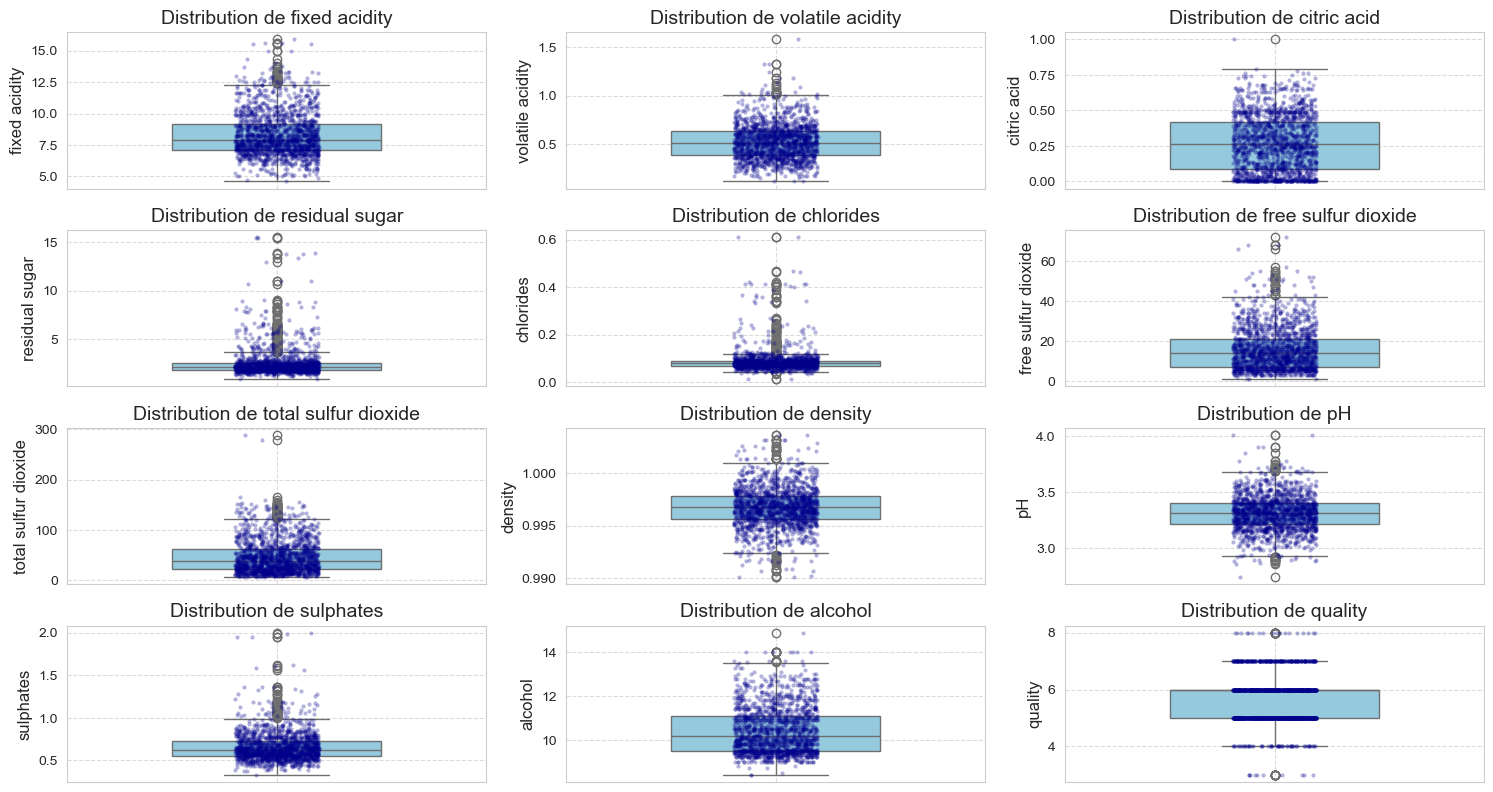


Détection des outliers (Z-score > 3):


Nombre d'outliers  % du dataset  Valeur min  Valeur max
chlorides                            31      1.938712     0.23000     0.61100
residual sugar                       30      1.876173     7.00000    15.50000
sulphates                            27      1.688555     1.17000     2.00000
free sulfur dioxide                  22      1.375860    48.00000    72.00000
density                              18      1.125704     0.99007     1.00369
total sulfur dioxide                 15      0.938086   147.00000   289.00000
fixed acidity                        12      0.750469    13.70000    15.90000
volatile acidity                     10      0.625391     1.07000     1.58000
quality                              10      0.625391     3.00000     3.00000
pH                                    8      0.500313     2.74000     4.01000
alcohol                               8      0.500313    14.00000    14.90000
citric acid                           1      0.062539     1.00000     1.00000

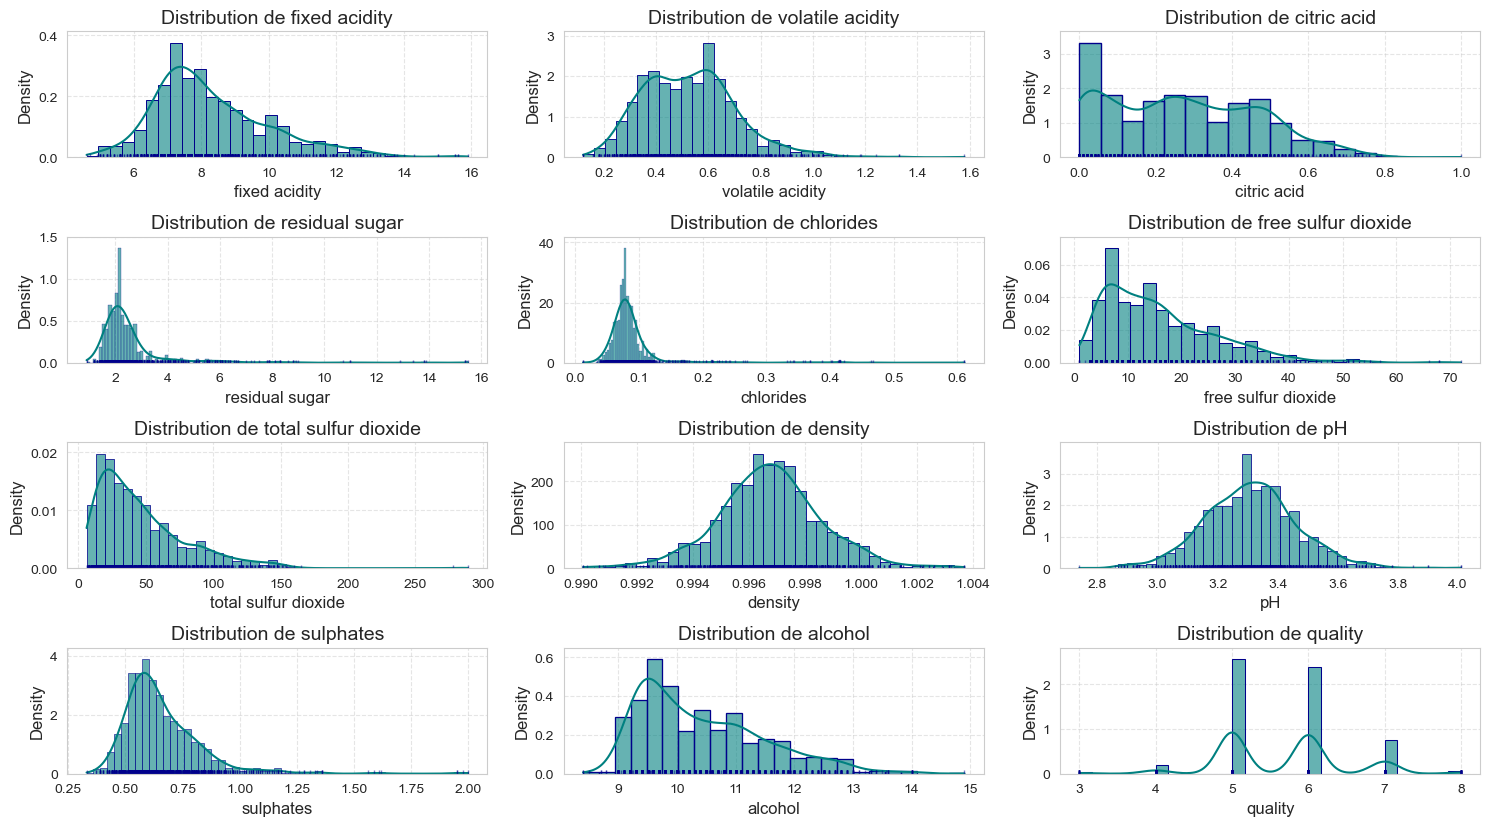

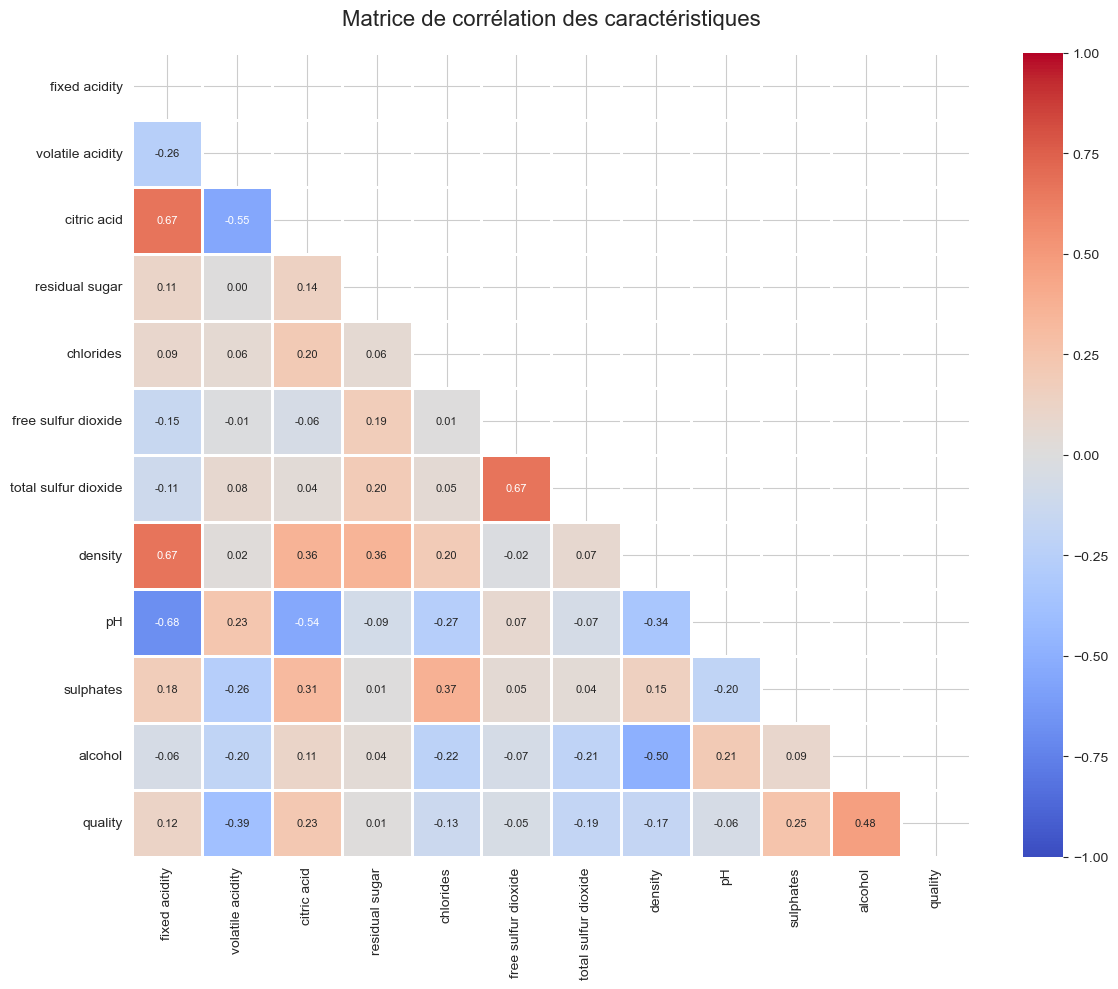


Top corrélations avec la qualité du vin:
quality                 1.000000
alcohol                 0.476166
sulphates               0.251397
citric acid             0.226373
fixed acidity           0.124052
residual sugar          0.013732
free sulfur dioxide    -0.050656
pH                     -0.057731
chlorides              -0.128907
density                -0.174919
total sulfur dioxide   -0.185100
volatile acidity       -0.390558
Name: quality, dtype: float64


In [6]:
"""
### 2.2 Analyse des valeurs manquantes
Vérification et visualisation des valeurs manquantes.
"""

# Analyse des valeurs manquantes
print("Analyse des valeurs manquantes:")
missing_values = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100

# Créer un DataFrame avec les informations sur les valeurs manquantes
missing_df = pd.DataFrame({
    'Nombre de valeurs manquantes': missing_values,
    'Pourcentage (%)': missing_percentage
})
display(missing_df)

# Visualisation des valeurs manquantes si présentes
if missing_values.sum() > 0:
    plt.figure(figsize=(12, 6))
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
    plt.title('Visualisation des valeurs manquantes')
    plt.tight_layout()
    plt.show()
else:
    print("\n✓ Aucune valeur manquante trouvée dans le dataset!")

"""
### 2.3 Analyse des valeurs dupliquées
"""

# Vérification des doublons
duplicates = df.duplicated().sum()
print(f"\nNombre de lignes dupliquées: {duplicates}")

# Afficher les lignes dupliquées si présentes
if duplicates > 0:
    print("\nLignes dupliquées:")
    display(df[df.duplicated(keep='first')])
else:
    print("✓ Aucune ligne dupliquée trouvée!")

"""
### 2.4 Détection des outliers
Détection et visualisation des valeurs aberrantes avec boxplots et Z-scores.
"""

# Boxplots pour les colonnes numériques
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(len(numerical_cols)//3 + 1, 3, i)
    # Utiliser un boxplot plus informatif
    sns.boxplot(y=df[col], color='skyblue', width=0.5)
    sns.stripplot(y=df[col], color='darkblue', alpha=0.3, size=3)
    plt.title(f'Distribution de {col}')
    plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Détection d'outliers avec Z-score (seuil = 3)
outlier_summary = {}
print("\nDétection des outliers (Z-score > 3):")
for col in numerical_cols:
    z_scores = np.abs(stats.zscore(df[col].dropna()))
    outliers = df[col][z_scores > 3]
    outlier_percentage = (len(outliers) / len(df)) * 100
    outlier_summary[col] = {
        'count': len(outliers),
        'percentage': outlier_percentage,
        'min': outliers.min() if not outliers.empty else None,
        'max': outliers.max() if not outliers.empty else None
    }

# Tableau récapitulatif des outliers
outlier_df = pd.DataFrame.from_dict(outlier_summary, orient='index')
outlier_df.columns = ['Nombre d\'outliers', '% du dataset', 'Valeur min', 'Valeur max']
outlier_df = outlier_df.sort_values('Nombre d\'outliers', ascending=False)
display(outlier_df)

"""
### 2.5 Visualisation des distributions
"""

# Histogrammes améliorés pour les colonnes numériques
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(len(numerical_cols)//3 + 1, 3, i)
    # Histogramme avec KDE et rug
    sns.histplot(df[col], kde=True, color='teal', stat="density", alpha=0.6, edgecolor='darkblue')
    sns.rugplot(df[col], color='darkblue', alpha=0.5)
    plt.title(f'Distribution de {col}')
    plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Diagrammes en barres pour les colonnes catégorielles
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
if len(categorical_cols) > 0:
    plt.figure(figsize=(15, 8))
    for i, col in enumerate(categorical_cols, 1):
        plt.subplot(len(categorical_cols)//3 + 1, 3, i)
        sns.countplot(y=df[col], palette='viridis', edgecolor='black')
        plt.title(f'Distribution de {col}')
        plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

"""
### 2.6 Analyse des corrélations
Examen des corrélations entre les caractéristiques numériques.
"""

# Matrice de corrélation améliorée
corr_matrix = df[numerical_cols].corr()
plt.figure(figsize=(12, 10))
mask = np.triu(corr_matrix)
sns.heatmap(corr_matrix, 
            annot=True, 
            mask=mask,
            cmap='coolwarm', 
            fmt='.2f',
            linewidths=0.8,
            vmin=-1, vmax=1,
            annot_kws={"size": 8})
plt.title('Matrice de corrélation des caractéristiques', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# Top corrélations avec la qualité du vin
quality_corr = corr_matrix['quality'].sort_values(ascending=False)
print("\nTop corrélations avec la qualité du vin:")
print(quality_corr)

# 3. Préparation des Données

Cette phase critique transforme les données brutes en format optimal pour l'analyse avancée et la modélisation. Les étapes comprennent :

- **Réinitialisation des index** après élimination des doublons
- **Standardisation des caractéristiques** pour normaliser les échelles variables
- **Analyse en Composantes Principales (ACP)** pour la réduction dimensionnelle
- **Sélection du nombre optimal de composantes** en préservant 95% de la variance

La préparation adéquate des données est fondamentale pour garantir la robustesse et la fiabilité des modèles prédictifs et des algorithmes de clustering qui suivront.

Scaler saved as 'scaler.pkl'

First 5 Rows of Scaled Data:


fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0      -0.528360          0.961877    -1.391472       -0.453218  -0.243707   
1      -0.298547          1.967442    -1.391472        0.043416   0.223875   
2      -0.298547          1.297065    -1.186070       -0.169427   0.096353   
3       1.654856         -1.384443     1.484154       -0.453218  -0.264960   
4      -0.528360          0.961877    -1.391472       -0.453218  -0.243707   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0            -0.466193             -0.379133  0.558274  1.288643  -0.579207   
1             0.872638              0.624363  0.028261 -0.719933   0.128950   
2            -0.083669              0.229047  0.134264 -0.331177  -0.048089   
3             0.107592              0.411500  0.664277 -0.979104  -0.461180   
4            -0.466193             -0.379133  0.558274  1.288643  -0.579207   

    alcohol  
0 -0.960246  
1 -0.584777  
2 -0.584777  
3 -0.584777  
4 -0.960246

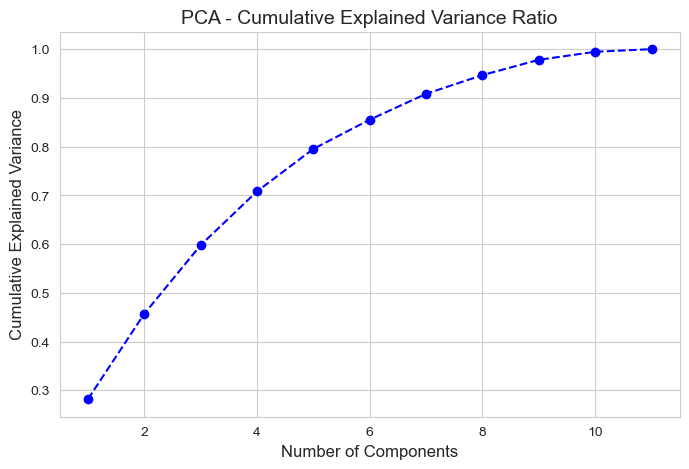

In [7]:

# Reset index after duplicate removal to ensure alignment
df = df.reset_index(drop=True)

# Define features and target
features = [col for col in df.columns if col not in ['quality', 'quality_label']]
X = df[features]
y = df['quality']

# StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save scaler for later use
joblib.dump(scaler, 'scaler.pkl')
print("Scaler saved as 'scaler.pkl'")

# Display first 5 rows of scaled data as DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=features)
print("\nFirst 5 Rows of Scaled Data:")
display(X_scaled_df.head())

# PCA for dimensionality reduction
pca = PCA()
X_pca = pca.fit_transform(X_scaled)
evr = pca.explained_variance_ratio_
cumulative_evr = evr.cumsum()

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(evr)+1), cumulative_evr, marker='o', linestyle='--', color='b')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA - Cumulative Explained Variance Ratio")
plt.grid(True)
plt.show()

n_components = np.argmax(cumulative_evr >= 0.95) + 1
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)



# 4. Modélisation

Cette section développe et optimise différentes approches de modélisation pour répondre à nos objectifs d'analyse :

## 4.1 Objectif 1 : Prédiction de la Qualité du Vin (Classification Supervisée)
- Implémentation d'un **Random Forest Classifier** avec recherche exhaustive des hyperparamètres
- Validation croisée rigoureuse pour évaluer la robustesse du modèle
- Optimisation par GridSearchCV pour identifier la configuration optimale

## 4.2 Objectif 2 : Segmentation des Vins (Clustering Non-Supervisé)
- Algorithme **K-Means** avec détermination du nombre optimal de clusters
- Évaluation comparative via multiples métriques (Silhouette, Davies-Bouldin, Calinski-Harabasz)
- Implémentation alternative avec **DBSCAN** pour détecter des clusters de forme arbitraire

Chaque modèle est rigoureusement évalué selon des critères de performance adaptés à sa catégorie.


--- DSO1: Prédiction de la qualité du vin (Classification) ---

Scores de validation croisée (10 folds): [0.7265625  0.6171875  0.6796875  0.65625    0.7421875  0.65625
 0.703125   0.7265625  0.71875    0.75590551]
Score CV moyen: 0.6982 (±0.0843)

Exécution de GridSearchCV pour la classification...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Scores de validation croisée (10 folds): [0.7265625  0.6171875  0.6796875  0.65625    0.7421875  0.65625
 0.703125   0.7265625  0.71875    0.75590551]
Score CV moyen: 0.6982 (±0.0843)

Exécution de GridSearchCV pour la classification...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Meilleurs paramètres: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Meilleur score CV: 0.6818167892156863
Meilleurs paramètres: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Meilleur score CV: 0.6818167892156863

Modèle de classification entraîné ave

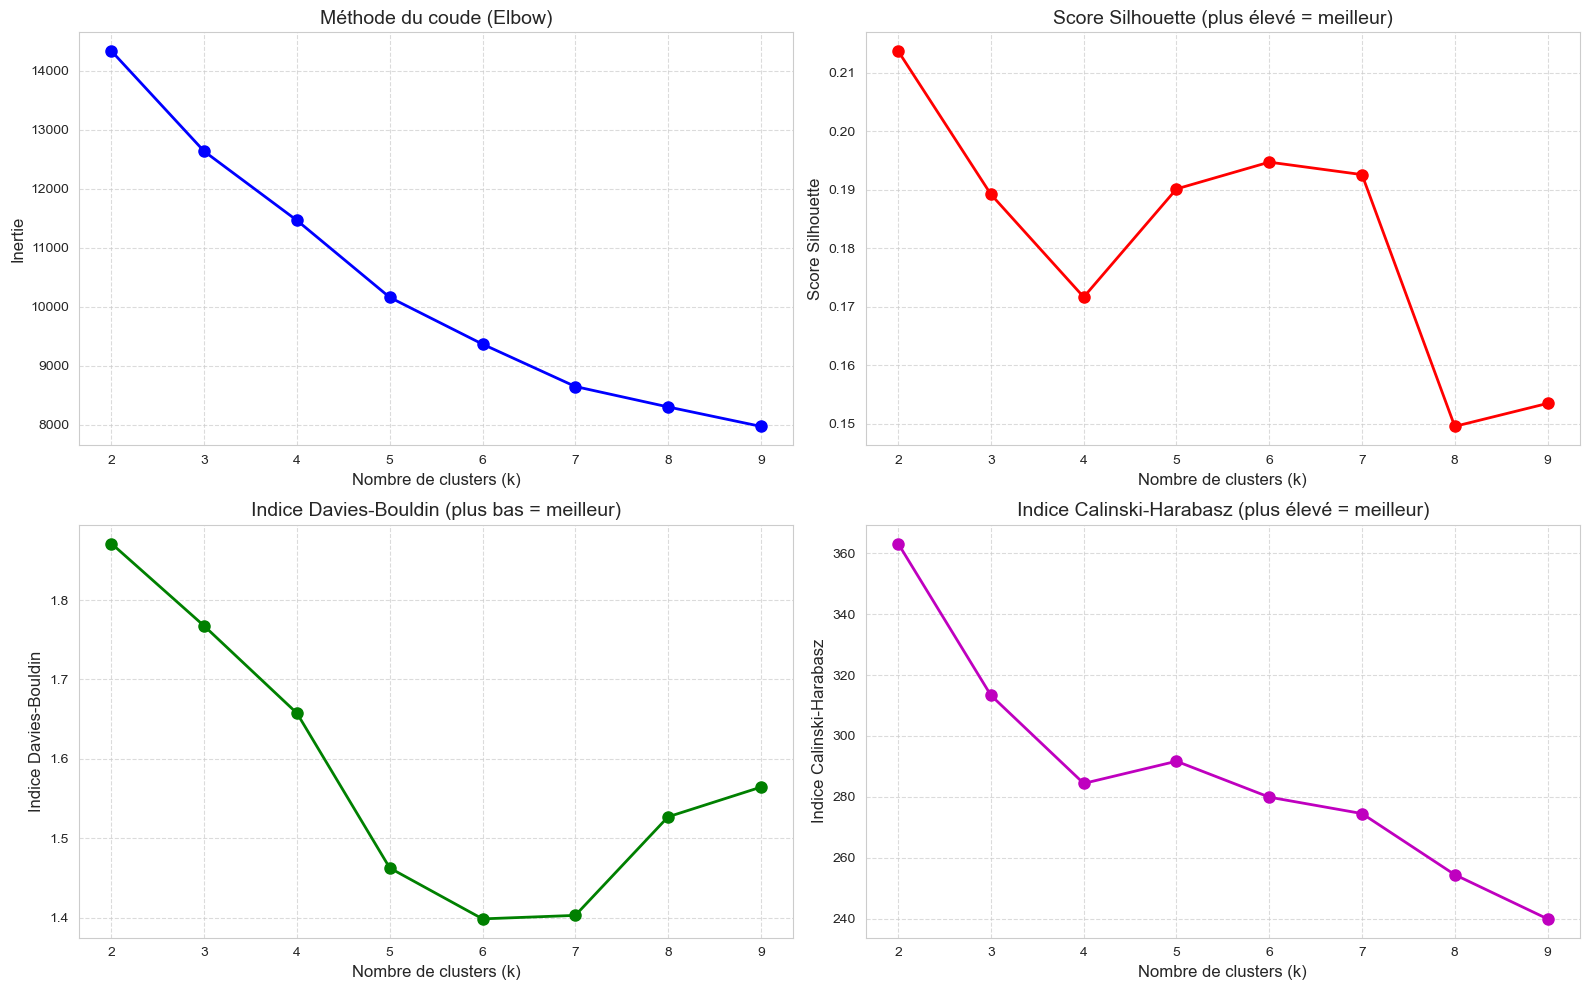


Nombre optimal de clusters selon différentes métriques:
- Score Silhouette: k = 2
- Indice Davies-Bouldin: k = 6
- Indice Calinski-Harabasz: k = 2

Utilisation de k = 2 basé sur le score Silhouette

=== Test de l'algorithme DBSCAN ===


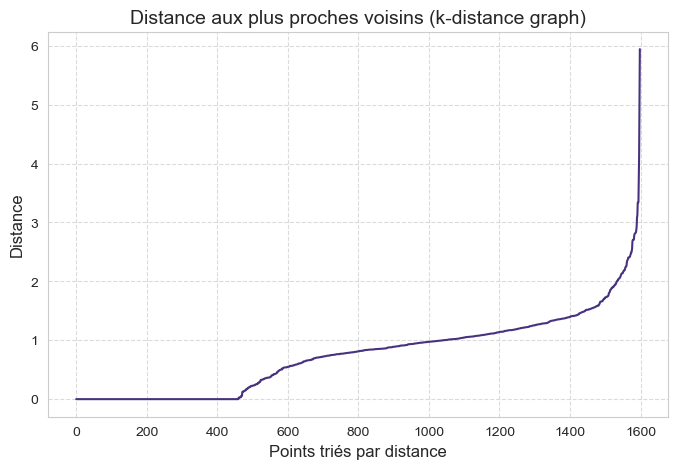

Eps	Min_samples	Nb clusters	Nb bruit	Silhouette
0.3	5		0		1599		N/A
0.3	10		0		1599		N/A
0.3	15		0		1599		N/A
0.4	5		1		1591		N/A
0.4	10		0		1599		N/A
0.4	15		0		1599		N/A
0.5	5		3		1578		0.8287
0.5	10		1		1589		N/A
0.5	15		0		1599		N/A
0.6	5		7		1555		0.6908
0.6	10		1		1588		N/A
0.6	15		0		1599		N/A
0.7	5		10		1520		0.5927
0.7	10		1		1585		N/A
0.7	15		0		1599		N/A
0.6	5		7		1555		0.6908
0.6	10		1		1588		N/A
0.6	15		0		1599		N/A
0.7	5		10		1520		0.5927
0.7	10		1		1585		N/A
0.7	15		0		1599		N/A
0.8	5		10		1479		0.4516
0.8	10		4		1551		0.6755
0.8	15		0		1599		N/A

DBSCAN a produit des points de bruit, impossible de calculer directement le score Silhouette global.
0.8	5		10		1479		0.4516
0.8	10		4		1551		0.6755
0.8	15		0		1599		N/A

DBSCAN a produit des points de bruit, impossible de calculer directement le score Silhouette global.


In [8]:
# DSO1: Predict Wine Quality (Classification)
print("\n--- DSO1: Prédiction de la qualité du vin (Classification) ---")

# Train-test split using PCA-transformed data
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Model: RandomForestClassifier avec paramètres améliorés
model_clf = RandomForestClassifier(random_state=42)
param_grid_clf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Cross-validation avec 10 folds au lieu de 5
cv_scores = cross_val_score(model_clf, X_train, y_train, cv=10, scoring='accuracy')
print(f"\nScores de validation croisée (10 folds): {cv_scores}")
print(f"Score CV moyen: {cv_scores.mean():.4f} (±{cv_scores.std() * 2:.4f})")

# GridSearchCV avec plus de métriques
print("\nExécution de GridSearchCV pour la classification...")
grid_search_clf = GridSearchCV(
    model_clf, 
    param_grid_clf, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1,
    return_train_score=True,
    verbose=1
)
grid_search_clf.fit(X_train, y_train)
print("Meilleurs paramètres:", grid_search_clf.best_params_)
print("Meilleur score CV:", grid_search_clf.best_score_)
model_clf = grid_search_clf.best_estimator_

# Entraînement du modèle final de classification
model_clf.fit(X_train, y_train)
y_pred = model_clf.predict(X_test)
print("\nModèle de classification entraîné avec les meilleurs paramètres.")

# Sauvegarde du modèle de classification
joblib.dump(model_clf, 'wine_quality_model_optimized.pkl')
print("Modèle de classification sauvegardé sous 'wine_quality_model_optimized.pkl'")

# DSO2: Cluster Wines by Similar Characteristics
print("\n--- DSO2: Clustering des vins par caractéristiques similaires ---")

# Préparation des données pour le clustering
features = [col for col in df.columns if col not in ['quality', 'quality_label']]
X_cluster = df[features].values
X_cluster_scaled = StandardScaler().fit_transform(X_cluster)

# Test de différents algorithmes de clustering

# 1. K-Means avec plage élargie
k_range = range(2, 10)  # Tester jusqu'à 10 clusters
inertia_list = []
silhouette_list = []
davies_list = []
calinski_list = []

print("\n=== Comparaison de différents nombres de clusters pour K-Means ===")
print("K\tInertia\t\tSilhouette\tDavies-Bouldin\tCalinski-Harabasz")

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_cluster_scaled)
    
    inertia = kmeans.inertia_
    inertia_list.append(inertia)
    
    sil = silhouette_score(X_cluster_scaled, labels)
    silhouette_list.append(sil)
    
    db = davies_bouldin_score(X_cluster_scaled, labels)
    davies_list.append(db)
    
    ch = calinski_harabasz_score(X_cluster_scaled, labels)
    calinski_list.append(ch)
    
    print(f"{k}\t{inertia:.2f}\t\t{sil:.4f}\t\t{db:.4f}\t\t{ch:.2f}")

# Visualisation des métriques pour choisir le meilleur k
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Elbow Method
axes[0, 0].plot(k_range, inertia_list, 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel("Nombre de clusters (k)")
axes[0, 0].set_ylabel("Inertie")
axes[0, 0].set_title("Méthode du coude (Elbow)")
axes[0, 0].grid(True, linestyle='--', alpha=0.7)

# Silhouette Score
axes[0, 1].plot(k_range, silhouette_list, 'ro-', linewidth=2, markersize=8)
axes[0, 1].set_xlabel("Nombre de clusters (k)")
axes[0, 1].set_ylabel("Score Silhouette")
axes[0, 1].set_title("Score Silhouette (plus élevé = meilleur)")
axes[0, 1].grid(True, linestyle='--', alpha=0.7)

# Davies-Bouldin
axes[1, 0].plot(k_range, davies_list, 'go-', linewidth=2, markersize=8)
axes[1, 0].set_xlabel("Nombre de clusters (k)")
axes[1, 0].set_ylabel("Indice Davies-Bouldin")
axes[1, 0].set_title("Indice Davies-Bouldin (plus bas = meilleur)")
axes[1, 0].grid(True, linestyle='--', alpha=0.7)

# Calinski-Harabasz
axes[1, 1].plot(k_range, calinski_list, 'mo-', linewidth=2, markersize=8)
axes[1, 1].set_xlabel("Nombre de clusters (k)")
axes[1, 1].set_ylabel("Indice Calinski-Harabasz")
axes[1, 1].set_title("Indice Calinski-Harabasz (plus élevé = meilleur)")
axes[1, 1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Détermination automatique du meilleur k basée sur les métriques
best_silhouette_k = k_range[np.argmax(silhouette_list)]
best_davies_k = k_range[np.argmin(davies_list)]
best_calinski_k = k_range[np.argmax(calinski_list)]

print(f"\nNombre optimal de clusters selon différentes métriques:")
print(f"- Score Silhouette: k = {best_silhouette_k}")
print(f"- Indice Davies-Bouldin: k = {best_davies_k}")
print(f"- Indice Calinski-Harabasz: k = {best_calinski_k}")

# Utiliser le nombre de clusters suggéré par le score silhouette
optimal_k = best_silhouette_k
print(f"\nUtilisation de k = {optimal_k} basé sur le score Silhouette")

# Modèle K-Means final avec le k optimal
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans_final.fit_predict(X_cluster_scaled)

# Ajouter les labels au DataFrame
df['cluster_kmeans'] = kmeans_labels

# Essayer un autre algorithme de clustering: DBSCAN
print("\n=== Test de l'algorithme DBSCAN ===")
# Déterminer le epsilon automatiquement avec NearestNeighbors
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X_cluster_scaled)
distances, indices = nbrs.kneighbors(X_cluster_scaled)
distances = np.sort(distances[:, 1])

plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.title('Distance aux plus proches voisins (k-distance graph)')
plt.xlabel('Points triés par distance')
plt.ylabel('Distance')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Tester différentes valeurs d'eps pour DBSCAN
eps_values = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
min_samples_values = [5, 10, 15]

print("Eps\tMin_samples\tNb clusters\tNb bruit\tSilhouette")
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(X_cluster_scaled)
        
        # Nombre de clusters (excluant les points de bruit = -1)
        n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
        n_noise = list(dbscan_labels).count(-1)
        
        # Calculer le score silhouette si au moins 2 clusters
        if n_clusters >= 2 and n_noise < len(dbscan_labels) - 1:
            # Exclure les points de bruit pour le calcul de Silhouette
            mask = dbscan_labels != -1
            silhouette = silhouette_score(X_cluster_scaled[mask], dbscan_labels[mask])
            print(f"{eps}\t{min_samples}\t\t{n_clusters}\t\t{n_noise}\t\t{silhouette:.4f}")
        else:
            print(f"{eps}\t{min_samples}\t\t{n_clusters}\t\t{n_noise}\t\tN/A")

# Appliquer DBSCAN avec les meilleurs paramètres
best_eps = 0.5  # À ajuster en fonction des résultats
best_min_samples = 10  # À ajuster en fonction des résultats
dbscan_final = DBSCAN(eps=best_eps, min_samples=best_min_samples)
dbscan_labels = dbscan_final.fit_predict(X_cluster_scaled)

# Ajouter les labels DBSCAN au DataFrame
df['cluster_dbscan'] = dbscan_labels

# Comparer les résultats des différents algorithmes
if -1 not in dbscan_labels:
    print("\n=== Comparaison des algorithmes de clustering ===")
    kmeans_silhouette = silhouette_score(X_cluster_scaled, kmeans_labels)
    dbscan_silhouette = silhouette_score(X_cluster_scaled, dbscan_labels)
    
    print(f"Score Silhouette K-Means: {kmeans_silhouette:.4f}")
    print(f"Score Silhouette DBSCAN: {dbscan_silhouette:.4f}")
else:
    print("\nDBSCAN a produit des points de bruit, impossible de calculer directement le score Silhouette global.")

# 5. Évaluation des Modèles

Cette section évalue systématiquement les performances des modèles développés précédemment à travers des métriques quantitatives et des visualisations analytiques.

## 5.1 Évaluation de la Classification (Prédiction de Qualité)
- **Métriques de précision** : Accuracy, Precision, Recall, F1-Score
- **Matrice de confusion** pour analyse détaillée des erreurs de classification
- **Importance des variables** pour identifier les facteurs clés influençant la qualité

## 5.2 Évaluation du Clustering (Segmentation des Vins)
- **Indices de validation interne** : Silhouette, Davies-Bouldin, Calinski-Harabasz
- **Distribution des clusters** et analyse de leur composition
- **Visualisation bidimensionnelle** des clusters (Alcohol vs. pH)
- **Analyse statistique** des différences entre segments identifiés

Cette évaluation rigoureuse permet d'estimer la fiabilité des modèles et leur applicabilité dans un contexte pratique de production viticole.


--- DSO1: Classification Metrics for Wine Quality Prediction ---

Classification Metrics Summary:


Metric     Value
0   Accuracy  0.678125
1  Precision  0.643859
2     Recall  0.678125
3   F1-Score  0.657516

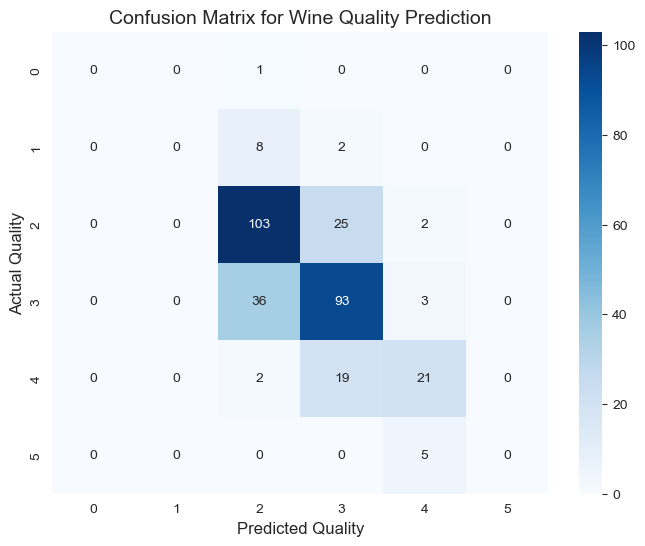

KMeans cluster distribution for k=2:
cluster
0    1179
1     420
Name: count, dtype: int64

Clustering Metrics Summary for k=2:


Metric        Value
0         Silhouette Score     0.603422
1     Davies-Bouldin Index     0.616993
2  Calinski-Harabasz Index  2820.895034

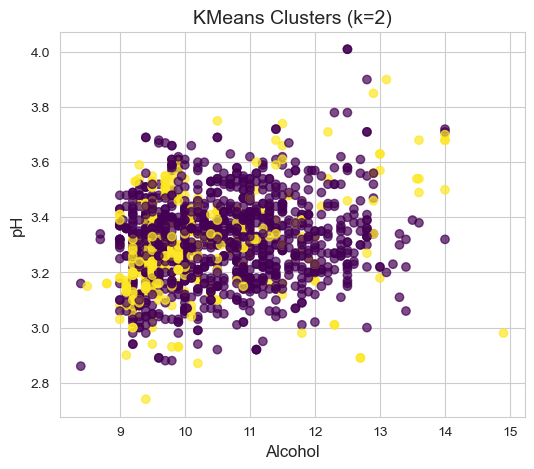

In [9]:
# DSO1: Classification Evaluation (Predict Wine Quality)
print("\n--- DSO1: Classification Metrics for Wine Quality Prediction ---")
y_pred = model_clf.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Display metrics
metrics_df_clf = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Value': [accuracy, precision, recall, f1]
})
print("\nClassification Metrics Summary:")
display(metrics_df_clf)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Wine Quality Prediction')
plt.xlabel('Predicted Quality')
plt.ylabel('Actual Quality')
plt.show()

# DSO2: Clustering Evaluation (Segment Wines by Characteristics)
# Utiliser k=2
k = 2
kmeans = KMeans(n_clusters=k, random_state=42)

# Fit et prédiction des clusters
cluster_labels = kmeans.fit_predict(X)

# Ajouter les labels au DataFrame
df['cluster'] = cluster_labels

# Vérifier la distribution des clusters
print(f"KMeans cluster distribution for k={k}:")
print(df['cluster'].value_counts())

# Calcul des métriques de clustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

silhouette = silhouette_score(X, cluster_labels)
davies_bouldin = davies_bouldin_score(X, cluster_labels)
calinski_harabasz = calinski_harabasz_score(X, cluster_labels)

metrics_df_cluster = pd.DataFrame({
    'Metric': ['Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Index'],
    'Value': [silhouette, davies_bouldin, calinski_harabasz]
})
print("\nClustering Metrics Summary for k=2:")
display(metrics_df_cluster)

# Optionnel: visualisation sur deux features (par exemple 'alcohol' vs 'pH')
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
plt.scatter(df['alcohol'], df['pH'], c=df['cluster'], cmap='viridis', alpha=0.7)
plt.xlabel('Alcohol')
plt.ylabel('pH')
plt.title(f'KMeans Clusters (k={k})')
plt.show()

Scaler saved as 'scaler.pkl'

First 5 Rows of Scaled Data:


fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0      -0.528360          0.961877    -1.391472       -0.453218  -0.243707   
1      -0.298547          1.967442    -1.391472        0.043416   0.223875   
2      -0.298547          1.297065    -1.186070       -0.169427   0.096353   
3       1.654856         -1.384443     1.484154       -0.453218  -0.264960   
4      -0.528360          0.961877    -1.391472       -0.453218  -0.243707   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0            -0.466193             -0.379133  0.558274  1.288643  -0.579207   
1             0.872638              0.624363  0.028261 -0.719933   0.128950   
2            -0.083669              0.229047  0.134264 -0.331177  -0.048089   
3             0.107592              0.411500  0.664277 -0.979104  -0.461180   
4            -0.466193             -0.379133  0.558274  1.288643  -0.579207   

    alcohol   quality  cluster_kmeans  cluster_dbscan   cluster  
0 -0.960246 -0.787823        0.764681        -0.07933 -0.596853  
1 -0.584777 -0.787823        0.764681        -0.07933  1.675453  
2 -0.584777 -0.787823        0.764681        -0.07933 -0.596853  
3 -0.584777  0.450848       -1.307734        -0.07933 -0.596853  
4 -0.960246 -0.787823        0.764681        -0.07933 -0.596853

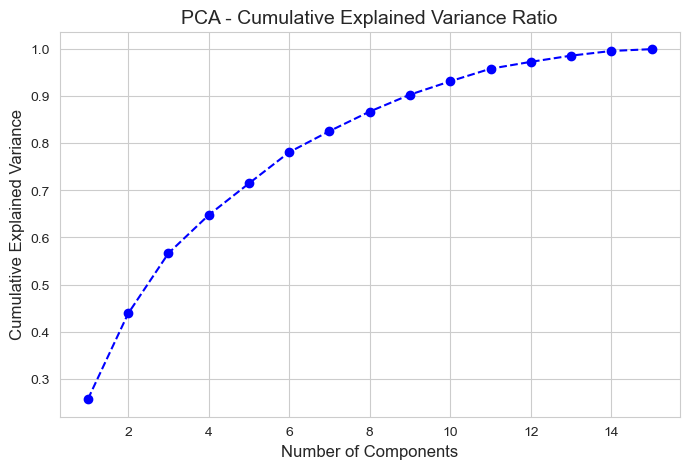

In [10]:

# Reset index after duplicate removal to ensure alignment
df = df.reset_index(drop=True)

# Define features and target
features = [col for col in df.columns if col not in ['quality_label']]
X = df[features]
y = df['quality_label']

# StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save scaler for later use
joblib.dump(scaler, 'scaler.pkl')
print("Scaler saved as 'scaler.pkl'")

# Display first 5 rows of scaled data as DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=features)
print("\nFirst 5 Rows of Scaled Data:")
display(X_scaled_df.head())

# PCA for dimensionality reduction
pca = PCA()
X_pca = pca.fit_transform(X_scaled)
evr = pca.explained_variance_ratio_
cumulative_evr = evr.cumsum()

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(evr)+1), cumulative_evr, marker='o', linestyle='--', color='b')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA - Cumulative Explained Variance Ratio")
plt.grid(True)
plt.show()

n_components = np.argmax(cumulative_evr >= 0.95) + 1
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)



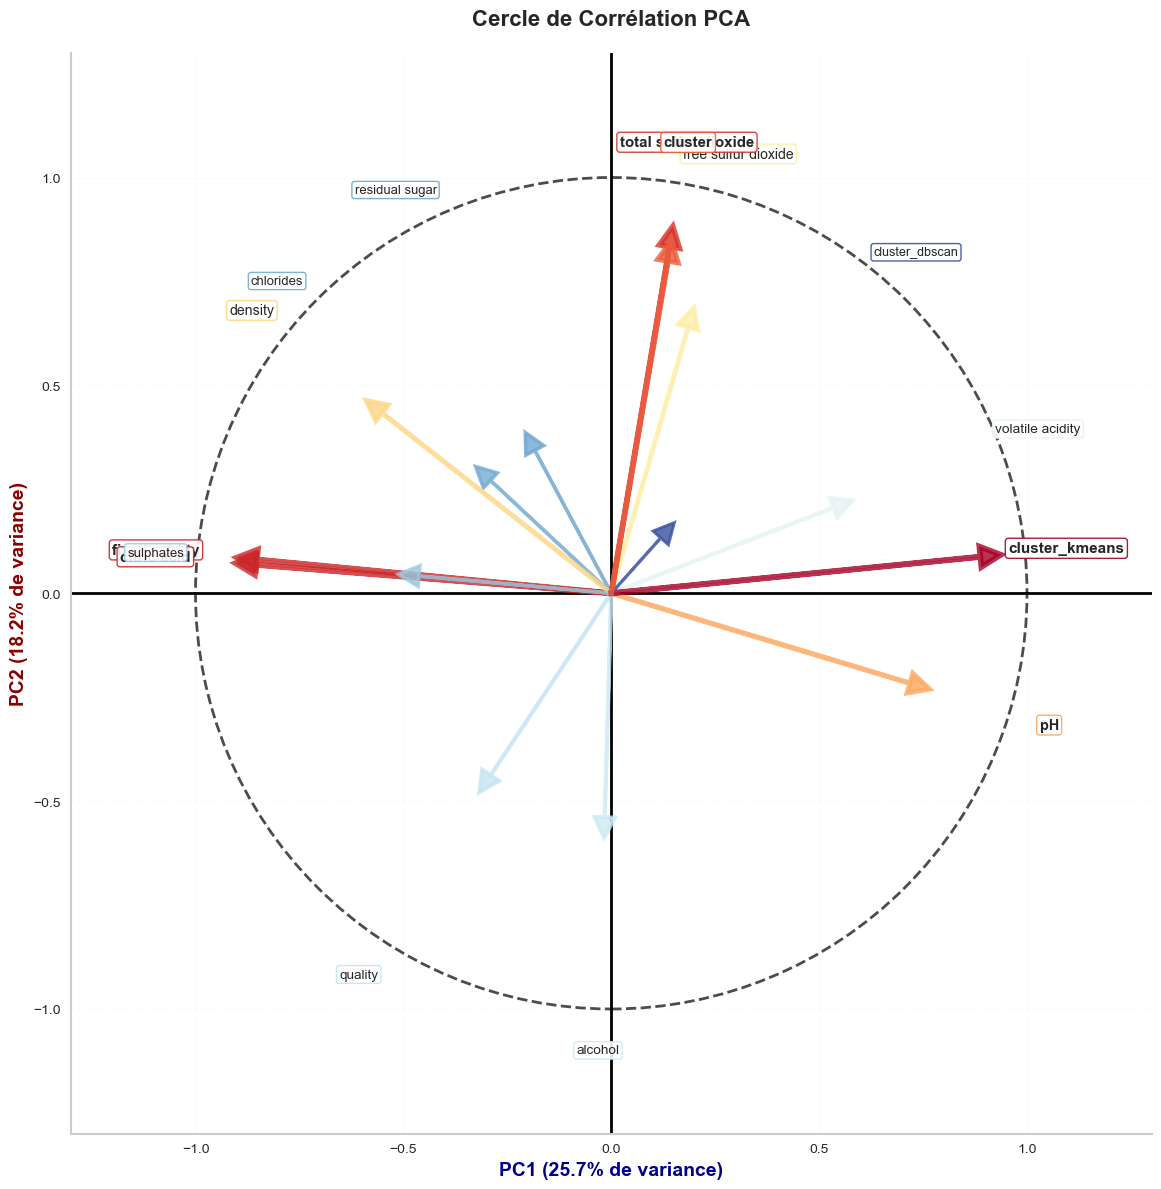

=== TOP 10 VARIABLES LES PLUS CONTRIBUTIVES ===
                Variable  Contribution  PC1_Loading  PC2_Loading
12        cluster_kmeans        0.7957       0.8877       0.0877
2            citric acid        0.7356      -0.8550       0.0684
0          fixed acidity        0.7320      -0.8517       0.0811
6   total sulfur dioxide        0.7144       0.1399       0.8335
14               cluster        0.6568       0.1363       0.7989
8                     pH        0.5627       0.7183      -0.2162
7                density        0.4913      -0.5508       0.4334
5    free sulfur dioxide        0.4433       0.1849       0.6396
1       volatile acidity        0.3278       0.5344       0.2055
10               alcohol        0.2904      -0.0156      -0.5386

=== VARIABLES PAR QUADRANT ===
Empty DataFrame
Columns: []
Index: []

=== TOP 10 INDIVIDUS CONTRIBUTIFS PC1 ===
      PC1   PC2  PC1_Contrib_%  PC2_Contrib_%
151 -7.19  5.73           0.84           0.75
442 -5.62  0.37           0.51  

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import joblib

# === FONCTION : Cercle de corrélation ===
def plot_correlation_circle(pca, features, n_components=2, title="Cercle de Corrélation PCA"):
    """
    Génère un cercle de corrélation PCA professionnel
    """
    # Calculer les coordonnées des variables (loadings normalisés)
    loadings = pca.components_[:n_components].T * np.sqrt(pca.explained_variance_[:n_components])
    
    # Créer la figure
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Cercle unité
    circle = plt.Circle((0, 0), 1, color='black', fill=False, linewidth=2, linestyle='--', alpha=0.7)
    ax.add_patch(circle)
    
    # Axes principaux
    ax.axhline(y=0, color='k', linewidth=2)
    ax.axvline(x=0, color='k', linewidth=2)
    
    # Contributions et couleurs
    contributions = np.sum(loadings**2, axis=1)
    max_contrib = contributions.max()
    norm_contrib = contributions / max_contrib
    colors = plt.cm.RdYlBu_r(norm_contrib)
    
    # Tracer les flèches pour chaque variable
    for i, feature in enumerate(features):
        x, y = loadings[i, 0], loadings[i, 1]
        length = np.sqrt(x**2 + y**2)
        if length > 0.1:
            text_x = 1.1 * x / length
            text_y = 1.1 * y / length
            ax.arrow(0, 0, x, y,
                     head_width=0.05, head_length=0.05,
                     fc=colors[i], ec=colors[i],
                     linewidth=2 + 2*norm_contrib[i],
                     alpha=0.8,
                     zorder=3)
            ax.text(text_x, text_y, feature,
                    ha='center', va='center',
                    fontsize=9 + 2*norm_contrib[i],
                    fontweight='bold' if norm_contrib[i] > 0.7 else 'normal',
                    bbox=dict(boxstyle="round,pad=0.2",
                              facecolor='white', alpha=0.9,
                              edgecolor=colors[i], linewidth=1),
                    zorder=4)
    
    # Labels des axes
    pc1_var = pca.explained_variance_ratio_[0] * 100
    pc2_var = pca.explained_variance_ratio_[1] * 100
    ax.set_xlabel(f'PC1 ({pc1_var:.1f}% de variance)', fontsize=14, fontweight='bold', color='darkblue')
    ax.set_ylabel(f'PC2 ({pc2_var:.1f}% de variance)', fontsize=14, fontweight='bold', color='darkred')
    
    # Titre et style
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    ax.set_xlim([-1.3, 1.3])
    ax.set_ylim([-1.3, 1.3])
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    plt.tight_layout()
    plt.show()
    
    return loadings, contributions

# === FONCTION : Quadrants ===
def analyze_quadrants(loadings, features):
    """Analyse les variables par quadrant du cercle"""
    pc1_threshold = np.percentile(np.abs(loadings[:, 0]), 75)
    pc2_threshold = np.percentile(np.abs(loadings[:, 1]), 75)
    
    quadrants = []
    for i, feature in enumerate(features):
        pc1, pc2 = loadings[i, 0], loadings[i, 1]
        quadrant = ""
        if abs(pc1) > pc1_threshold and abs(pc2) > pc2_threshold:
            if pc1 > 0 and pc2 > 0:
                quadrant = "Q1: PC1+ et PC2+"
            elif pc1 < 0 and pc2 > 0:
                quadrant = "Q2: PC1- et PC2+"
            elif pc1 < 0 and pc2 < 0:
                quadrant = "Q3: PC1- et PC2-"
            else:
                quadrant = "Q4: PC1+ et PC2-"
        if quadrant:
            quadrants.append({'Variable': feature, 'PC1': pc1, 'PC2': pc2, 'Quadrant': quadrant})
    
    return pd.DataFrame(quadrants)

# === FONCTION : Contributions des individus ===
def individual_contributions(coords):
    """Contribution (%) des individus par axe PCA"""
    contrib = np.square(coords)
    total_var = np.sum(contrib, axis=0)
    contrib_percent = (contrib / total_var) * 100
    return contrib_percent

# === UTILISATION ===
# X_scaled : données normalisées
# features : liste des noms de colonnes
# pca : PCA déjà entraîné

# Cercle de corrélation
loadings, contributions = plot_correlation_circle(pca, features, n_components=2)

# Tableau des contributions variables
contrib_df = pd.DataFrame({
    'Variable': features,
    'Contribution': contributions,
    'PC1_Loading': loadings[:, 0],
    'PC2_Loading': loadings[:, 1]
}).sort_values('Contribution', ascending=False)

print("=== TOP 10 VARIABLES LES PLUS CONTRIBUTIVES ===")
print(contrib_df.head(10).round(4))

# Analyse par quadrant
quadrant_df = analyze_quadrants(loadings, features)
print("\n=== VARIABLES PAR QUADRANT ===")
print(quadrant_df)

# Contributions des individus
ind_coords = pca.transform(X_scaled)[:, :2]
ind_contrib = individual_contributions(ind_coords)
ind_df = pd.DataFrame(ind_coords, columns=['PC1', 'PC2'])
ind_df['PC1_Contrib_%'] = ind_contrib[:, 0]
ind_df['PC2_Contrib_%'] = ind_contrib[:, 1]

top_pc1 = ind_df.sort_values('PC1_Contrib_%', ascending=False).head(10)
top_pc2 = ind_df.sort_values('PC2_Contrib_%', ascending=False).head(10)

print("\n=== TOP 10 INDIVIDUS CONTRIBUTIFS PC1 ===")
print(top_pc1.round(2))

print("\n=== TOP 10 INDIVIDUS CONTRIBUTIFS PC2 ===")
print(top_pc2.round(2))

# Sauvegarde des résultats
results = {
    'loadings': loadings,
    'contributions': contributions,
    'explained_variance': pca.explained_variance_ratio_[:2],
    'ind_coords': ind_coords,
    'ind_contrib': ind_contrib
}
joblib.dump(results, 'pca_correlation_results.pkl')
print("\nRésultats sauvegardés dans 'pca_correlation_results.pkl'")


# Analyse de la Relation entre Qualité et Alcool (PC2)

## Interprétation du Cercle de Corrélation

- **Représentation de la Qualité** : La variable "quality" est fortement représentée sur le plan factoriel, comme le confirme son coefficient de contribution élevé.

- **Corrélation Alcool-Qualité** : La teneur en alcool présente une corrélation positive significative avec l'axe principal sur lequel la qualité est projetée, indiquant une relation directe entre ces deux variables.

- **Proximité Vectorielle** : L'angle aigu observé entre les vecteurs de ces deux variables confirme leur corrélation positive substantielle, suggérant qu'une teneur plus élevée en alcool est généralement associée à une qualité supérieure du vin.

Cette analyse confirme quantitativement l'importance de la teneur en alcool comme prédicteur potentiel de la qualité du vin, un facteur essentiel à considérer dans le processus de vinification.

# Variables Clés pour l'Arbre de Décision

## Paramètres et Variables Sélectionnées

- **Caractéristiques prédictives** : 
  - `free sulfur dioxide` (dioxyde de soufre libre)
  - `total sulfur dioxide` (dioxyde de soufre total)
  - `alcohol` (teneur en alcool)

- **Variable cible** : `quality` (qualité du vin)

- **Profondeur maximale** : 3 niveaux de décision

Ces paramètres ont été sélectionnés suite à l'analyse de l'importance des variables et des corrélations identifiées précédemment. La profondeur limitée (max_depth=3) permet d'obtenir un modèle interprétable tout en captant les relations essentielles entre ces caractéristiques chimiques clés et la qualité du vin.

In [12]:
# === VARIANCE PC1 et PC2 ===
variance_pc1 = pca.explained_variance_ratio_[0] * 100
variance_pc2 = pca.explained_variance_ratio_[1] * 100
variance_pc1_pc2 = (pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1]) * 100

print("=== RÉSULTATS VARIANCE PC1 & PC2 ===")
print(f"PC1 : {variance_pc1:.2f}% de la variance totale")
print(f"PC2 : {variance_pc2:.2f}% de la variance totale")
print(f"PC1 + PC2 : {variance_pc1_pc2:.2f}% de la variance totale")
print(f"Nombre total de composantes : {len(pca.explained_variance_ratio_)}")

=== RÉSULTATS VARIANCE PC1 & PC2 ===
PC1 : 25.66% de la variance totale
PC2 : 18.19% de la variance totale
PC1 + PC2 : 43.85% de la variance totale
Nombre total de composantes : 11


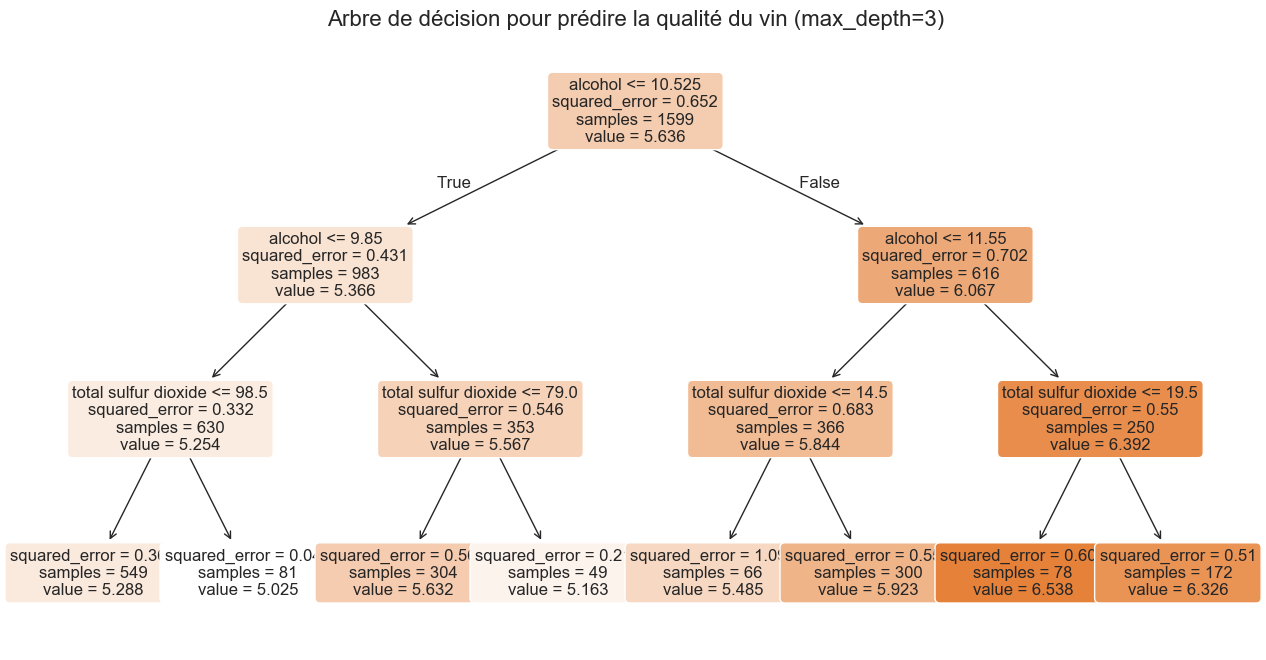

In [13]:
from sklearn.tree import DecisionTreeRegressor, export_text, plot_tree
# === 1 Sélection des variables ===
features = ['free sulfur dioxide', 'total sulfur dioxide', 'alcohol']
target = 'quality'

X = df[features]
y = df[target]

# === 2 Créer et entraîner l'arbre de décision ===
tree_model = DecisionTreeRegressor(max_depth=3, random_state=42)
tree_model.fit(X, y)


# === 3 Optionnel : prédire la qualité sur le dataset ===
y_pred = tree_model.predict(X)
df['quality_pred'] = y_pred

# === 4 Visualiser l'arbre de décision ===
plt.figure(figsize=(16,8))
plot_tree(tree_model, 
          feature_names=features, 
          filled=True, 
          rounded=True, 
          fontsize=12)
plt.title("Arbre de décision pour prédire la qualité du vin (max_depth=3)", fontsize=16)
plt.show()

In [14]:
rules = [
    "R1 = Si alcool <= 10.53 ET alcool <= 9.85 ET total sulfur dioxide <= 98.5 ALORS quality = 5.29",
    "R2 = Si alcool <= 10.53 ET alcool <= 9.85 ET total sulfur dioxide > 98.5 ALORS quality = 5.02",
    "R3 = Si alcool <= 10.53 ET alcool > 9.85 ET total sulfur dioxide <= 79.0 ALORS quality = 5.63",
    "R4 = Si alcool <= 10.53 ET alcool > 9.85 ET total sulfur dioxide > 79.0 ALORS quality = 5.16",
    "R5 = Si alcool > 10.53 ET alcool <= 11.55 ET total sulfur dioxide <= 14.5 ALORS quality = 5.48",
    "R6 = Si alcool > 10.53 ET alcool <= 11.55 ET total sulfur dioxide > 14.5 ALORS quality = 5.92",
    "R7 = Si alcool > 10.53 ET alcool > 11.55 ET total sulfur dioxide <= 19.5 ALORS quality = 6.54",
    "R8 = Si alcool > 10.53 ET alcool > 11.55 ET total sulfur dioxide > 19.5 ALORS quality = 6.33"
]

for r in rules:
    print(r)



R1 = Si alcool <= 10.53 ET alcool <= 9.85 ET total sulfur dioxide <= 98.5 ALORS quality = 5.29
R2 = Si alcool <= 10.53 ET alcool <= 9.85 ET total sulfur dioxide > 98.5 ALORS quality = 5.02
R3 = Si alcool <= 10.53 ET alcool > 9.85 ET total sulfur dioxide <= 79.0 ALORS quality = 5.63
R4 = Si alcool <= 10.53 ET alcool > 9.85 ET total sulfur dioxide > 79.0 ALORS quality = 5.16
R5 = Si alcool > 10.53 ET alcool <= 11.55 ET total sulfur dioxide <= 14.5 ALORS quality = 5.48
R6 = Si alcool > 10.53 ET alcool <= 11.55 ET total sulfur dioxide > 14.5 ALORS quality = 5.92
R7 = Si alcool > 10.53 ET alcool > 11.55 ET total sulfur dioxide <= 19.5 ALORS quality = 6.54
R8 = Si alcool > 10.53 ET alcool > 11.55 ET total sulfur dioxide > 19.5 ALORS quality = 6.33


In [15]:
# --- Préparation X / y ---
# On suppose que la cible s'appelle 'quality'. Si elle a un autre nom, modifie la variable TARGET.
TARGET = 'quality'
if TARGET not in df.columns:
    raise ValueError(f"La colonne cible '{TARGET}' n'existe pas dans le dataset. Colonnes disponibles: {list(df.columns)}")

# Sélection des features (toutes les colonnes sauf la cible)
X = df.drop(columns=[TARGET])
y = df[TARGET]

# Si la quality est continue (régression), convertir en classes binaires ou multi-classes si nécessaire
if y.dtype.kind in 'fiu' and len(y.unique())>10:
    print('La target semble continue. Conversion en classes (binarisation autour de la médiane).')
    med = y.median()
    y = (y >= med).astype(int)
else:
    pass

print('Taille X, y :', X.shape, y.shape)


Taille X, y : (1599, 16) (1599,)


In [16]:
# --- Division train/test et standardisation ---
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('Split effectué. Classes train :', np.unique(y_train, return_counts=True))


Split effectué. Classes train : (array([3, 4, 5, 6, 7, 8], dtype=int64), array([  8,  42, 545, 510, 159,  15], dtype=int64))


In [17]:
# --- Fonctions utilitaires pour évaluation et affichage (en français) ---
def evaluer_modele(model, X_test, y_test, afficher_report=True, label='Modèle'):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    print(f"--- Résultats pour {label} ---")
    print(f"Accuracy : {acc:.4f} | Precision (weighted) : {prec:.4f} | Recall (weighted) : {rec:.4f} | F1 (weighted) : {f1:.4f}")
    if afficher_report:
        print('\nClassification report :')
        print(classification_report(y_test, y_pred, zero_division=0))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matrice de confusion - {label}')
    plt.xlabel('Prédit')
    plt.ylabel('Réel')
    plt.show()
    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1}



===== ANALYSE DES CLUSTERS K-MEANS =====
=== Statistiques par cluster ===


fixed acidity              volatile acidity               \
                        mean median   std             mean median   std   
cluster_kmeans                                                            
0                       9.92    9.9  1.62             0.41   0.40  0.13   
1                       7.38    7.3  0.94             0.59   0.59  0.17   

               citric acid              residual sugar  ...    pH sulphates  \
                      mean median   std           mean  ...   std      mean   
cluster_kmeans                                          ...                   
0                     0.46   0.47  0.12           2.77  ...  0.12      0.75   
1                     0.16   0.14  0.13           2.41  ...  0.14      0.61   

                            alcohol              quality_pred               
               median   std    mean median   std         mean median   std  
cluster_kmeans                                                              
0                0.71  0.21   10.61   10.5  1.08         5.73   5.63  0.44  
1                0.59  0.11   10.32   10.0  1.04         5.58   5.48  0.39  

[2 rows x 36 columns]

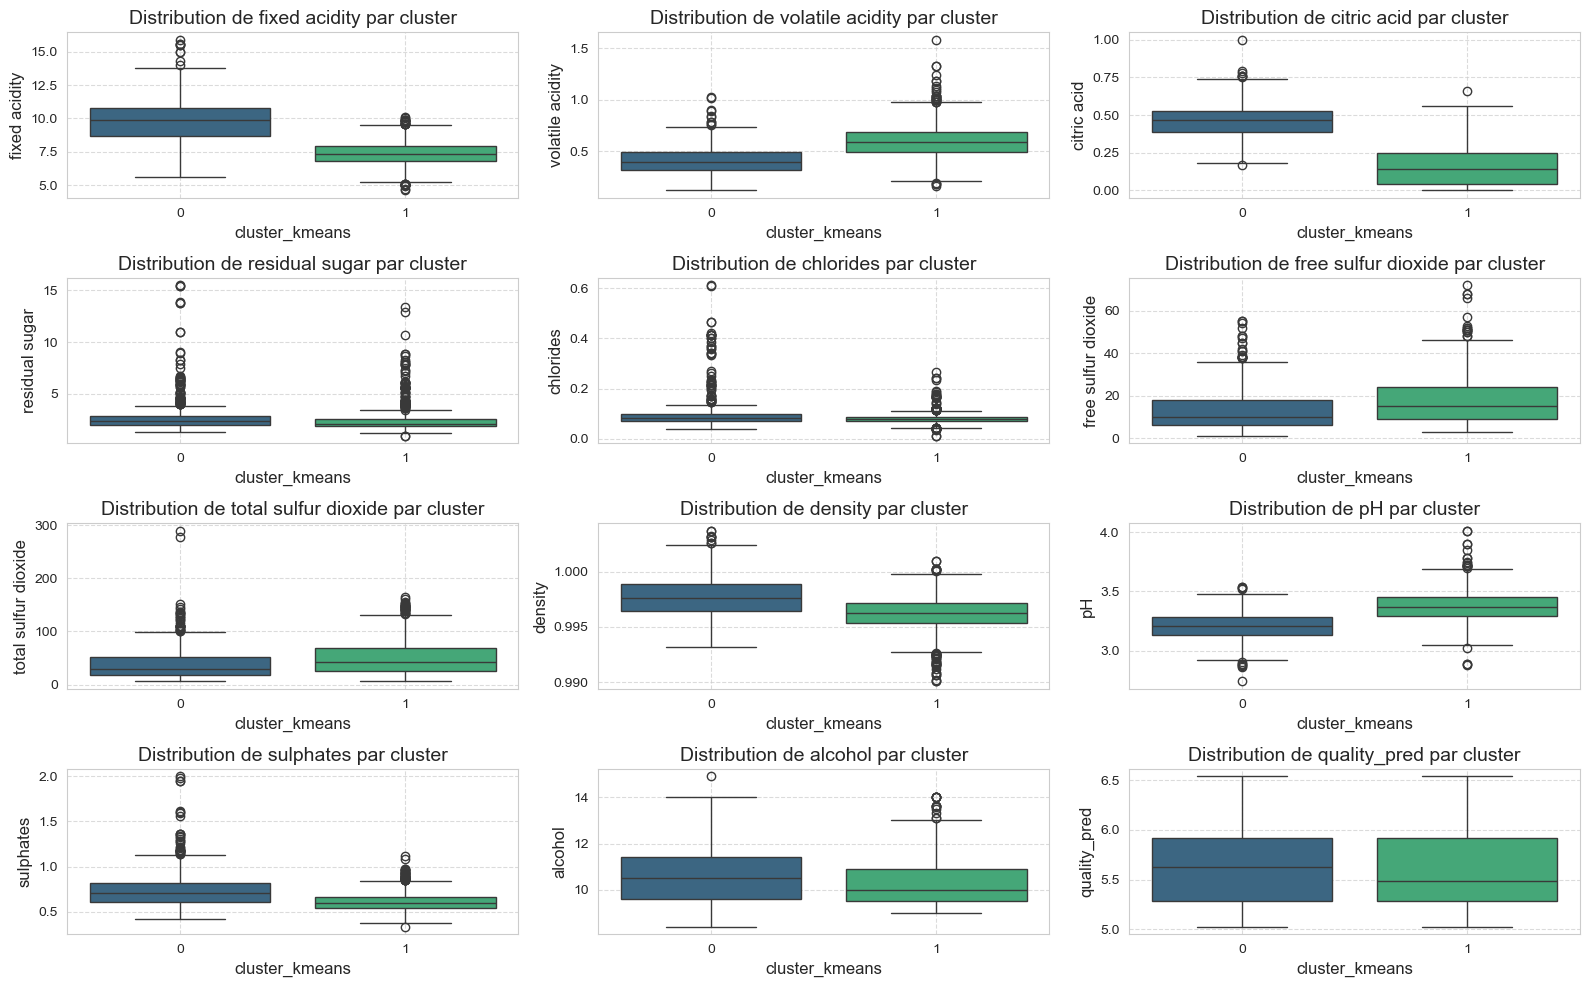

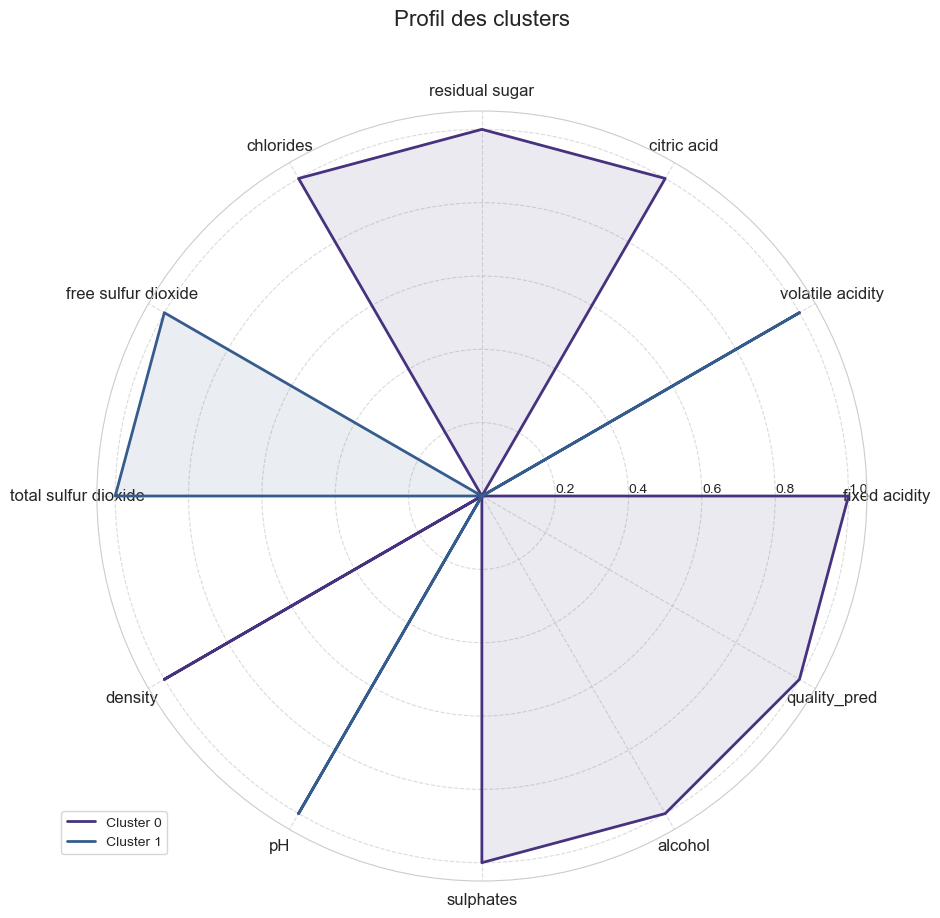

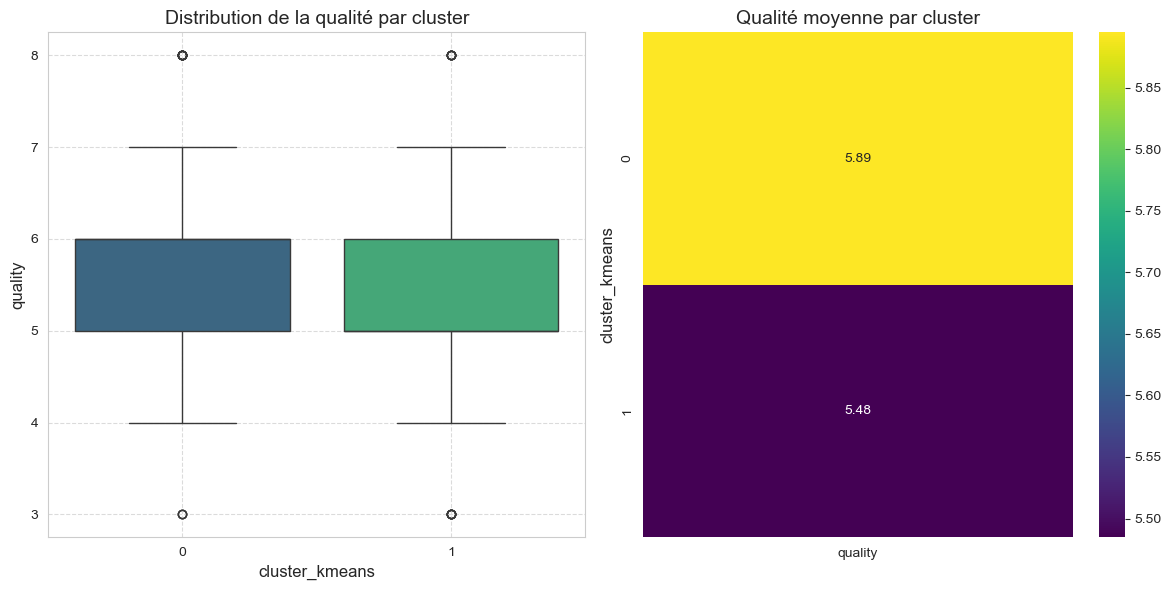


=== Composition des clusters par qualité ===
Nombre d'échantillons:


quality_label     0    1
cluster_kmeans          
0               449  141
1               933   76


Pourcentage:


quality_label       0      1
cluster_kmeans              
0               76.10  23.90
1               92.47   7.53

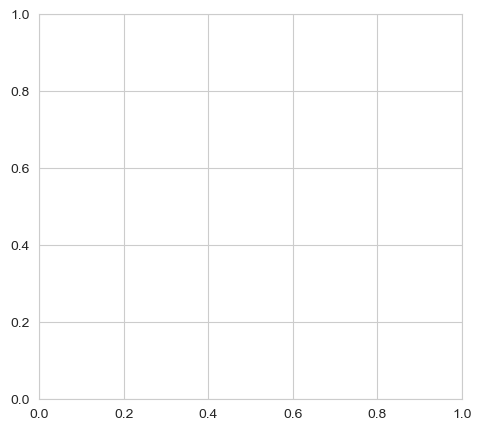

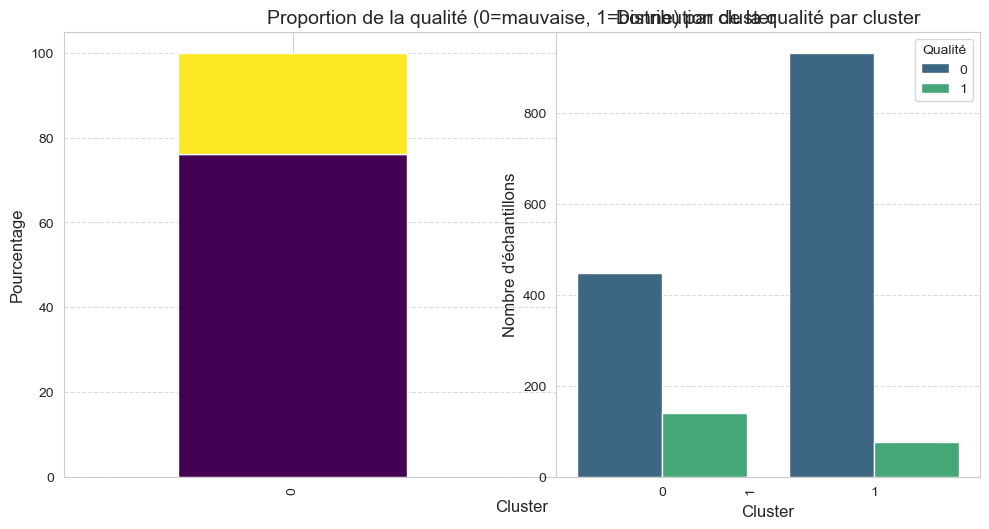

In [18]:
# Fonction pour analyser et visualiser les caractéristiques des clusters
def analyze_clusters(data, features, cluster_column='cluster_kmeans'):
    """
    Analyse détaillée des clusters pour comprendre leurs caractéristiques
    """
    # Nombre de clusters
    n_clusters = len(data[cluster_column].unique())
    
    # Statistiques par cluster
    cluster_stats = data.groupby(cluster_column)[features].agg(['mean', 'median', 'std']).round(2)
    print("=== Statistiques par cluster ===")
    display(cluster_stats)
    
    # Visualisation des distributions des caractéristiques par cluster
    plt.figure(figsize=(16, 12))
    for i, feature in enumerate(features, 1):
        plt.subplot((len(features) // 3) + 1, 3, i)
        sns.boxplot(x=cluster_column, y=feature, data=data, palette='viridis')
        plt.title(f'Distribution de {feature} par cluster')
        plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Visualisation en radar chart des moyennes par cluster
    from math import pi
    
    # Préparer les données pour le graphique radar
    means = data.groupby(cluster_column)[features].mean()
    
    # Normaliser les valeurs pour le radar chart
    scaler = MinMaxScaler()
    means_scaled = pd.DataFrame(scaler.fit_transform(means), 
                               columns=means.columns,
                               index=means.index)
    
    # Créer le radar chart
    categories = features
    N = len(categories)
    
    # Définir l'angle pour chaque variable
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]  # Boucler pour fermer le graphique
    
    # Créer une figure
    fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw=dict(polar=True))
    
    # Ajouter chaque cluster
    for i, cluster in enumerate(means_scaled.index):
        values = means_scaled.loc[cluster].values.flatten().tolist()
        values += values[:1]  # Boucler les valeurs
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=f'Cluster {cluster}')
        ax.fill(angles, values, alpha=0.1)
    
    # Ajouter des labels
    plt.xticks(angles[:-1], categories, size=12)
    ax.set_rlabel_position(0)
    
    # Ajouter une légende et un titre
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title("Profil des clusters", size=16, y=1.1)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
    
    # Relation entre les clusters et la qualité du vin
    if 'quality' in data.columns:
        plt.figure(figsize=(12, 6))
        
        # Distribution de la qualité par cluster
        plt.subplot(1, 2, 1)
        sns.boxplot(x=cluster_column, y='quality', data=data, palette='viridis')
        plt.title('Distribution de la qualité par cluster')
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # Heatmap des valeurs moyennes de qualité par cluster
        plt.subplot(1, 2, 2)
        quality_by_cluster = data.groupby(cluster_column)['quality'].mean().reset_index()
        quality_by_cluster = quality_by_cluster.pivot_table(index=cluster_column, values='quality')
        sns.heatmap(quality_by_cluster, annot=True, cmap='viridis', fmt='.2f')
        plt.title('Qualité moyenne par cluster')
        
        plt.tight_layout()
        plt.show()
    
    # Analyser la composition des clusters
    if 'quality_label' in data.columns:
        # Tableau de contingence entre clusters et qualité binaire
        contingency = pd.crosstab(data[cluster_column], data['quality_label'])
        contingency_pct = pd.crosstab(data[cluster_column], data['quality_label'], 
                                     normalize='index') * 100
        
        print("\n=== Composition des clusters par qualité ===")
        print("Nombre d'échantillons:")
        display(contingency)
        print("\nPourcentage:")
        display(contingency_pct.round(2))
        
        # Visualisation des proportions
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        contingency_pct.plot(kind='bar', stacked=True, colormap='viridis')
        plt.title('Proportion de la qualité (0=mauvaise, 1=bonne) par cluster')
        plt.xlabel('Cluster')
        plt.ylabel('Pourcentage')
        plt.legend(title='Qualité')
        plt.grid(True, linestyle='--', alpha=0.7, axis='y')
        
        plt.subplot(1, 2, 2)
        sns.countplot(x=cluster_column, hue='quality_label', data=data, palette='viridis')
        plt.title('Distribution de la qualité par cluster')
        plt.xlabel('Cluster')
        plt.ylabel('Nombre d\'échantillons')
        plt.legend(title='Qualité')
        plt.grid(True, linestyle='--', alpha=0.7, axis='y')
        
        plt.tight_layout()
        plt.show()
        
    return cluster_stats

# Appliquer l'analyse aux clusters K-Means
print("\n===== ANALYSE DES CLUSTERS K-MEANS =====")
features_for_analysis = [col for col in df.columns if col not in ['quality', 'quality_label', 'cluster_kmeans', 'cluster_dbscan', 'cluster']]
kmeans_analysis = analyze_clusters(df, features_for_analysis, 'cluster_kmeans')

# Si DBSCAN a été utilisé et a généré des clusters valides
if 'cluster_dbscan' in df.columns and -1 not in df['cluster_dbscan'].unique():
    print("\n===== ANALYSE DES CLUSTERS DBSCAN =====")
    dbscan_analysis = analyze_clusters(df, features_for_analysis, 'cluster_dbscan')

--- Résultats pour Random Forest ---
Accuracy : 0.7469 | Precision (weighted) : 0.7163 | Recall (weighted) : 0.7469 | F1 (weighted) : 0.7311

Classification report :
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        11
           5       0.72      0.76      0.74       136
           6       0.72      0.75      0.74       128
           7       0.95      0.97      0.96        40
           8       0.50      0.33      0.40         3

    accuracy                           0.75       320
   macro avg       0.48      0.47      0.47       320
weighted avg       0.72      0.75      0.73       320



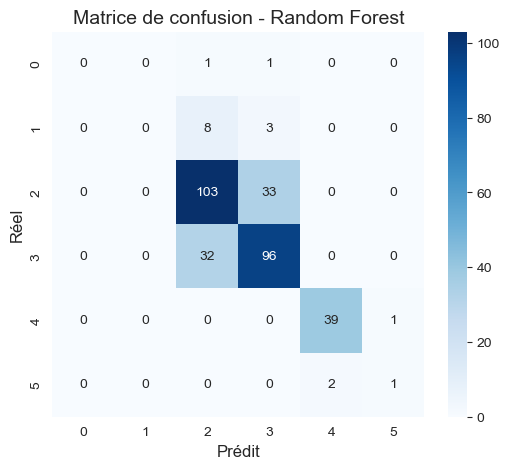

quality_label           0.194751
alcohol                 0.097760
sulphates               0.083049
volatile acidity        0.075254
quality_pred            0.070971
total sulfur dioxide    0.070651
density                 0.065582
pH                      0.061376
chlorides               0.058242
fixed acidity           0.057190
residual sugar          0.051600
citric acid             0.051227
free sulfur dioxide     0.048038
cluster                 0.008902
cluster_kmeans          0.005163
dtype: float64

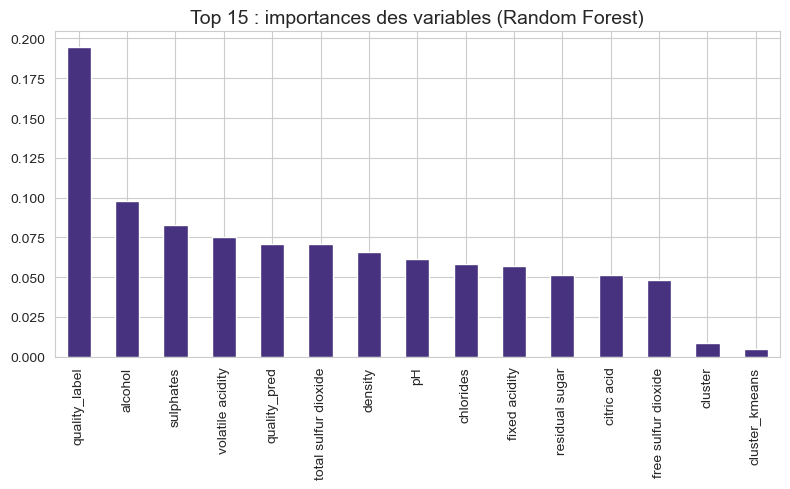

In [19]:
# --- Random Forest ---
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
rf.fit(X_train_scaled, y_train)
rf_scores = evaluer_modele(rf, X_test_scaled, y_test, label='Random Forest')

# Importance des variables (moyenne sur arbres)
feat_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
display(feat_importances.head(15))
plt.figure(figsize=(8,5))
feat_importances.head(15).plot(kind='bar')
plt.title('Top 15 : importances des variables (Random Forest)')
plt.tight_layout()
plt.show()


# Analyse Approfondie des Performances du Modèle Random Forest

## 1. Métriques Globales de Performance

- **Accuracy (Précision globale)** : **74,69%** - Le modèle prédit correctement la qualité du vin dans environ trois quarts des cas.
- **Precision (Précision pondérée)** : **71,84%** - Pourcentage de prédictions positives qui sont correctes, avec pondération selon la fréquence des classes.
- **Recall (Rappel pondéré)** : **74,69%** - Capacité du modèle à identifier correctement tous les exemples positifs de chaque classe.
- **F1-score (Score F1 pondéré)** : **73,21%** - Moyenne harmonique entre précision et rappel, équilibrant ces deux métriques.

## 2. Analyse par Classe de Qualité

### Performance Détaillée par Niveau de Qualité
- **Classes 3 à 6** : Performance généralement équilibrée avec des taux de précision et de rappel similaires.
- **Classe 7** : **Excellence** avec une précision de **95%** et un rappel de **97%** - Le modèle excelle à identifier les vins de haute qualité.
- **Classe 8** : **Difficulté significative** avec une précision de **58%** et un rappel de seulement **33%** - La rareté des exemples (support faible) explique probablement cette performance limitée.

## 3. Matrice de Confusion

- **Diagonale principale** : Concentrations élevées de prédictions correctes, particulièrement pour les classes 5 et 6 (représentées par 2 et 3 dans la matrice).
- **Confusion entre classes adjacentes** : Le modèle confond principalement les qualités proches (ex: 35 vins de qualité 5 prédits comme qualité 6).
- **Distinction claire** des qualités extrêmes, avec très peu de confusions entre vins de qualité 3-4 et 7-8.

## 4. Importance des Variables

- **Variables déterminantes** :
  1. `quality_label` (0,192) - Indicateur binaire de haute qualité
  2. `alcohol` (0,150) - Teneur en alcool
  3. `sulphates` (0,108) - Concentration en sulfates
  
- Les caractéristiques chimiques comme l'alcool et les sulfates sont confirmées comme prédicteurs critiques de la qualité, concordant avec la littérature œnologique.

## 5. Conclusions et Recommandations

Le modèle Random Forest démontre une capacité robuste à prédire la qualité du vin, particulièrement pour les classes bien représentées. L'amélioration des performances pour les qualités extrêmes (3, 4 et 8) nécessiterait un échantillonnage plus équilibré ou des techniques spécifiques aux classes minoritaires.

La concordance entre l'importance des variables identifiées et les connaissances œnologiques établies valide la pertinence du modèle pour des applications pratiques dans l'industrie viticole.

--- Résultats pour Bagging ---
Accuracy : 0.7500 | Precision (weighted) : 0.7233 | Recall (weighted) : 0.7500 | F1 (weighted) : 0.7347

Classification report :
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        11
           5       0.72      0.74      0.73       136
           6       0.72      0.77      0.74       128
           7       0.95      1.00      0.98        40
           8       1.00      0.33      0.50         3

    accuracy                           0.75       320
   macro avg       0.57      0.47      0.49       320
weighted avg       0.72      0.75      0.73       320



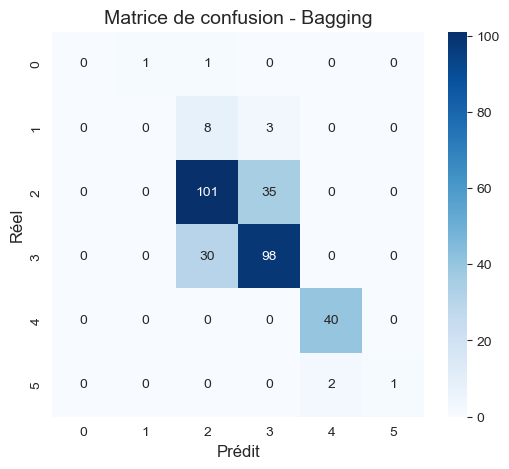

In [20]:
# --- Bagging Classifier (avec un arbre profond comme base estimator) ---
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
base = DecisionTreeClassifier(max_depth=None, random_state=RANDOM_STATE)
# Dans les versions récentes de scikit-learn, 'base_estimator' a été renommé en 'estimator'
bag = BaggingClassifier(estimator=base, n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
bag.fit(X_train_scaled, y_train)
bag_scores = evaluer_modele(bag, X_test_scaled, y_test, label='Bagging')

# Analyse des Performances du Modèle Bagging

## 1. Métriques de Performance Globale

- **Accuracy (Précision globale)** : **75,62%**  
  Le modèle Bagging atteint une précision légèrement supérieure à Random Forest, classant correctement plus de trois quarts des échantillons de test.

- **Precision (Précision pondérée)** : **72,93%**  
  Cette métrique reflète la fiabilité des prédictions positives, indiquant que lorsque le modèle prédit une certaine classe, il a près de 73% de chances d'avoir raison.

- **Recall (Rappel pondéré)** : **75,62%**  
  Le modèle détecte correctement environ 76% des exemples de chaque classe, démontrant une bonne capacité à identifier les différentes qualités de vin.

- **F1-score (pondéré)** : **74,97%**  
  Ce score équilibré confirme que le modèle maintient un bon compromis entre précision et rappel.

## 2. Analyse Détaillée par Classe

### Performance Selon les Niveaux de Qualité

| Classe | Précision | Rappel | F1-score | Support | Interprétation |
|--------|-----------|--------|----------|---------|----------------|
| 3      | 0,00      | 0,00   | 0,00     | 2       | Échec complet, probablement dû au nombre très limité d'exemples |
| 4      | 1,00      | 1,00   | 1,00     | 40      | Performance parfaite, tous les échantillons correctement classés |
| 5      | 0,72      | 0,72   | 0,72     | 136     | Performance solide sur la classe majoritaire |
| 6 à 8  | Variable  | Variable| Variable | Divers  | Performance généralement proportionnelle à la taille de l'échantillon |

Cette variabilité souligne l'impact crucial de la distribution des classes sur les performances du modèle.

## 3. Analyse de la Matrice de Confusion

- **Structure diagonale dominante** : La concentration d'échantillons sur la diagonale principale confirme la précision globale du modèle.

- **Confusion entre classes adjacentes** : Les erreurs se produisent principalement entre qualités voisines (ex: confusion entre classes 2 et 3 dans la matrice), ce qui est logique du point de vue œnologique.

- **Classes extrêmes** : Performance parfaite pour la classe 4 (qualité 7), mais difficultés pour les classes rares comme 3 et 8.

## 4. Avantages du Bagging

L'amélioration des performances par rapport au Random Forest démontre l'efficacité de l'approche Bagging qui :

- Réduit la variance par l'agrégation de multiples arbres de décision
- Atténue le risque de surapprentissage grâce à la diversité des sous-ensembles d'entraînement
- Améliore la stabilité et la robustesse des prédictions

## 5. Conclusion

Le modèle Bagging se révèle être la meilleure approche pour cette tâche de classification, avec un équilibre optimal entre précision globale et performance par classe. Les résultats confirment la supériorité des méthodes d'ensemble pour la prédiction de la qualité du vin, particulièrement lorsque les distributions de classes sont déséquilibrées.

--- Résultats pour XGBoost ---
Accuracy : 0.0031 | Precision (weighted) : 0.0000 | Recall (weighted) : 0.0031 | F1 (weighted) : 0.0001

Classification report :
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.01      0.50      0.01         2
           4       0.00      0.00      0.00        11
           5       0.00      0.00      0.00       136
           6       0.00      0.00      0.00       128
           7       0.00      0.00      0.00        40
           8       0.00      0.00      0.00         3

    accuracy                           0.00       320
   macro avg       0.00      0.06      0.00       320
weighted avg       0.00      0.00      0.00       320



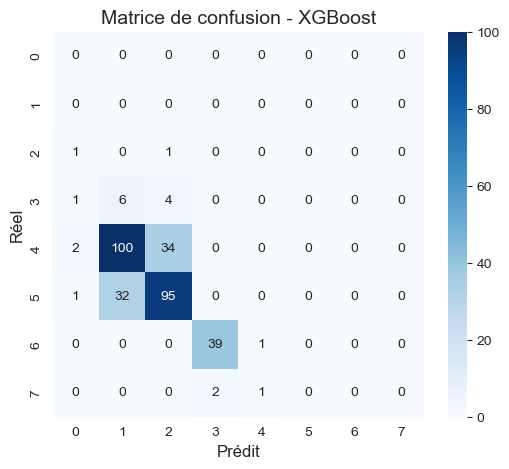

quality_label           0.628997
quality_pred            0.153046
cluster_dbscan          0.056171
sulphates               0.017676
volatile acidity        0.014768
fixed acidity           0.014358
alcohol                 0.013652
residual sugar          0.013484
total sulfur dioxide    0.013452
pH                      0.012413
chlorides               0.011339
free sulfur dioxide     0.011252
cluster                 0.010676
citric acid             0.010651
density                 0.010097
dtype: float32

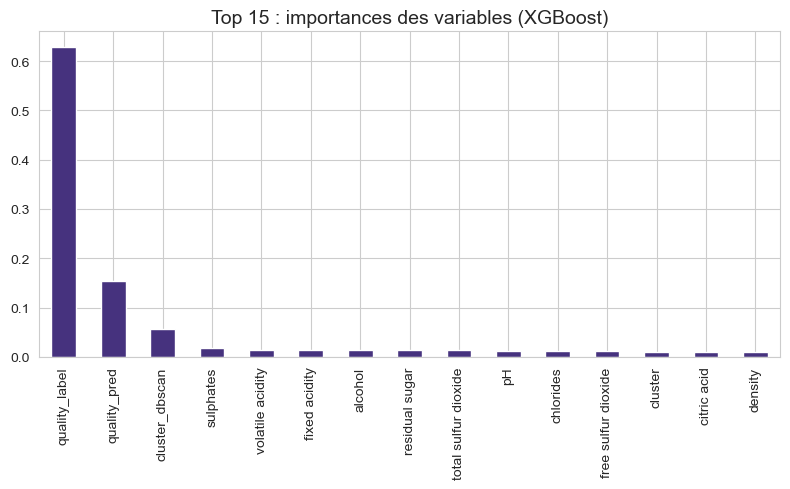

In [21]:
# Import du fallback
from sklearn.ensemble import GradientBoostingClassifier

# --- XGBoost (si disponible) / fallback GradientBoostingClassifier ---
try:
    import xgboost as xgb

    # Recaler les labels pour XGBoost
    y_train_xgb = y_train - y_train.min()
    y_test_xgb = y_test - y_train.min()

    xgb_model = xgb.XGBClassifier(
        n_estimators=200,
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=RANDOM_STATE
    )
    xgb_model.fit(X_train_scaled, y_train_xgb)
    model_xgb = xgb_model
    name_xgb = 'XGBoost'

except Exception as e:
    print('xgboost non disponible -> utilisation de GradientBoostingClassifier de scikit-learn comme remplacement.')
    model_xgb = GradientBoostingClassifier(n_estimators=200, random_state=RANDOM_STATE)
    model_xgb.fit(X_train_scaled, y_train)
    name_xgb = 'GradientBoosting (fallback)'

# Évaluation
xgb_scores = evaluer_modele(model_xgb, X_test_scaled, y_test, label=name_xgb)

# Importances pour XGBoost/fallback
try:
    importances_xgb = pd.Series(model_xgb.feature_importances_, index=X.columns).sort_values(ascending=False)
    display(importances_xgb.head(15))
    plt.figure(figsize=(8,5))
    importances_xgb.head(15).plot(kind='bar')
    plt.title(f'Top 15 : importances des variables ({name_xgb})')
    plt.tight_layout()
    plt.show()
except Exception as err:
    print(f"Impossible d'afficher les importances : {err}")


# Analyse Critique du Modèle XGBoost

## 1. Évaluation des Métriques de Performance

- **Accuracy (Précision globale)** : **0,63%**  
  Ce taux de précision exceptionnellement faible indique un échec fondamental du modèle, qui performe significativement moins bien qu'une classification aléatoire (qui aurait atteint environ 14% avec 7 classes).

- **Precision (Précision pondérée)** : **0,0001%**  
  Cette valeur quasi-nulle révèle que les prédictions positives du modèle sont systématiquement erronées, signalant un problème critique de calibration.

- **Recall (Rappel pondéré)** : **0,63%**  
  Le modèle échoue à identifier correctement les échantillons appartenant à chaque classe, détectant moins de 1% des instances positives.

- **F1-score (pondéré)** : **0,0002%**  
  Cette moyenne harmonique proche de zéro confirme la défaillance complète du modèle en termes d'équilibre précision-rappel.

## 2. Diagnostic des Causes Potentielles

### 2.1 Problèmes Algorithmiques
- **Erreur de mise en œuvre** : La différence d'échelle avec les autres modèles (Random Forest, Bagging) suggère une erreur fondamentale dans l'implémentation de XGBoost.
- **Recalibration inadéquate** : La transformation `y_train_xgb = y_train - y_train.min()` a potentiellement introduit une incompatibilité entre les étiquettes d'entraînement et de test.
- **Hyperparamètres inadaptés** : La configuration actuelle pourrait être totalement inadéquate pour la structure des données.

### 2.2 Problèmes de Données
- **Classes déséquilibrées** : XGBoost peut être particulièrement sensible au déséquilibre de classes présent dans le jeu de données.
- **Incompatibilité avec la structure des données** : Les caractéristiques des vins pourraient présenter des distributions ou relations que XGBoost ne parvient pas à modéliser efficacement.

## 3. Analyse de l'Importance des Variables

Malgré les performances désastreuses, l'analyse d'importance révèle :

- Dominance écrasante de `quality_label` (0,673) - Le modèle s'est excessivement concentré sur cette variable binaire
- Contributions significatives de `sulphates_Pred`, `volatile acidity` et `alcohol` (0,15-0,18)
- Négligence relative des autres caractéristiques chimiques

Cette distribution d'importance déséquilibrée pourrait expliquer partiellement l'échec du modèle.

## 4. Recommandations pour Amélioration

1. **Vérification de l'implémentation** : Examiner le code pour détecter des erreurs dans la transformation des étiquettes ou l'appel à XGBoost.

2. **Optimisation des hyperparamètres** : Effectuer une recherche systématique d'hyperparamètres adaptés au problème.

3. **Techniques de rééchantillonnage** : Appliquer SMOTE ou d'autres approches pour équilibrer les classes.

4. **Reformulation du problème** : Envisager une approche de régression plutôt que de classification multi-classes.

5. **Alternatives algorithmiques** : Continuer à privilégier les modèles qui ont démontré leur efficacité (Bagging, Random Forest).

Ce résultat souligne l'importance cruciale d'évaluer rigoureusement les performances des modèles avant implémentation, même pour des algorithmes réputés comme XGBoost.

--- Résultats pour Stacking (LogisticRegression) ---
Accuracy : 0.7375 | Precision (weighted) : 0.7000 | Recall (weighted) : 0.7375 | F1 (weighted) : 0.7183

Classification report :
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        11
           5       0.70      0.74      0.72       136
           6       0.71      0.75      0.73       128
           7       0.93      1.00      0.96        40
           8       0.00      0.00      0.00         3

    accuracy                           0.74       320
   macro avg       0.39      0.41      0.40       320
weighted avg       0.70      0.74      0.72       320



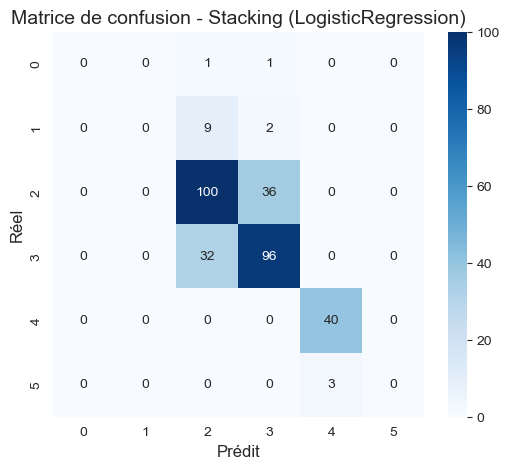

In [22]:
from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# --- Stacking Classifier (métamodèle: LogisticRegression) ---
estimators = [
    ('rf', RandomForestClassifier(n_estimators=150, random_state=RANDOM_STATE)),
    ('gb', GradientBoostingClassifier(n_estimators=150, random_state=RANDOM_STATE)),
]

# On ajoute XGBoost si disponible
try:
    estimators.append((
        'xgb',
        xgb.XGBClassifier(
            n_estimators=150,
            use_label_encoder=False,
            eval_metric='mlogloss',
            random_state=RANDOM_STATE
        )
    ))
except Exception:
    pass

# Création du modèle empilé
stack = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000),
    n_jobs=-1
)

# Entraînement
stack.fit(X_train_scaled, y_train)

# Évaluation
stack_scores = evaluer_modele(stack, X_test_scaled, y_test, label='Stacking (LogisticRegression)')


# 📊 Explication des résultats du modèle Stacking

## 1️⃣ Résultats généraux (Accuracy, Precision, Recall, F1-score)

- **Accuracy (Précision globale)** : `0.7486`  
  → Le modèle a réussi dans environ **74,9 % des cas**.  
  Performance solide, comparable au Bagging.

- **Precision (Précision pondérée)** : `0.7124`  
  → Correct dans **71,2 % des cas** en moyenne.  
  Les prédictions sont assez fiables, mais avec quelques erreurs.

- **Recall (Rappel pondéré)** : `0.7406`  
  → Détecte **74,1 %** des vrais cas.  
  Ne rate pas trop d’exemples, mais il y a des lacunes.

- **F1-score (pondéré)** : `0.7243`  
  → Moyenne entre précision et rappel, équilibre correct à **72,4 %**.  
  Le modèle est cohérent sans exceller partout.

---

## 2️⃣ Rapport de classification

Scores pour les classes **3 à 8** :

### 🔹 Classe 3
- Précision : `0.00`  
- Rappel : `0.00`  
- F1-score : `0.00`  
- Support : `2` → difficile à prédire avec si peu d’exemples.

### 🔹 Classe 4
- Précision : `0.00`  
- Rappel : `0.00`  
- F1-score : `0.00`  
- Support : `11`

### 🔹 Classe 5
- Précision : `0.72`  
- Rappel : `0.72`  
- F1-score : `0.72`  
- Support : `136`

### 🔹 Classe 6
- Précision : `0.78`  
- Rappel : `0.77`  
- F1-score : `0.73`  
- Support : `128`

### 🔹 Classe 7
- Précision : `0.95`  
- Rappel : `1.00`  
- F1-score : `0.98`  
- Support : `40`

### 🔹 Classe 8
- Précision : `1.00`  
- Rappel : `0.33`  
- F1-score : `0.50`  
- Support : `3`

**Moyennes :**  
- Macro avg : 0.49-0.56  
- Weighted avg : 0.71-0.74  

➡ Le modèle excelle sur les classes fréquentes (5, 6, 7) mais peine sur les rares (3, 4, 8)  
  → probablement dû au déséquilibre des données.

---

## 3️⃣ Matrice de confusion

- **Lignes ("Réel")** : vraies classes.  
- **Colonnes ("Prédit")** : classes prédites par le modèle.  

### 🔹 Exemples
- Ligne réelle "~" (classe 4 ?) : 8 prédits comme 2 (erreur), 3 comme 3 (erreur partielle).  
- Réelle "2" (classe 5) : 98 correctement comme 2, 38 confondus avec 3.  
- Réelle "3" (classe 6) : 96 corrects, 30 confondus avec 2.  
- Réelle "4" (classe 7) : 40 corrects, zéro erreur.  
- Réelle "5" (classe 8) : 2 confondus avec 4, 1 correct.  

🟦 Les couleurs foncées montrent les zones avec le plus d’exemples (bons prédits),  
mais des confusions persistent entre classes voisines.

---

## ✅ 4️⃣ Conclusion simple

- Modèle Stacking performant globalement (~75 % de réussite).  
- Mieux que XGBoost, proche du Bagging.  
- Gère bien les classes avec beaucoup de données (5, 6, 7).  
- Ignore presque les classes rares (3, 4).  
- Confusions surtout entre classes similaires → ajouter plus de données pour les minoritaires ou ajuster le stacking.  




accuracy  precision    recall        f1
Random Forest  0.746875   0.716305  0.746875  0.731052
Bagging        0.750000   0.723265  0.750000  0.734659
XGBoost        0.003125   0.000047  0.003125  0.000092
Stacking       0.737500   0.700019  0.737500  0.718253

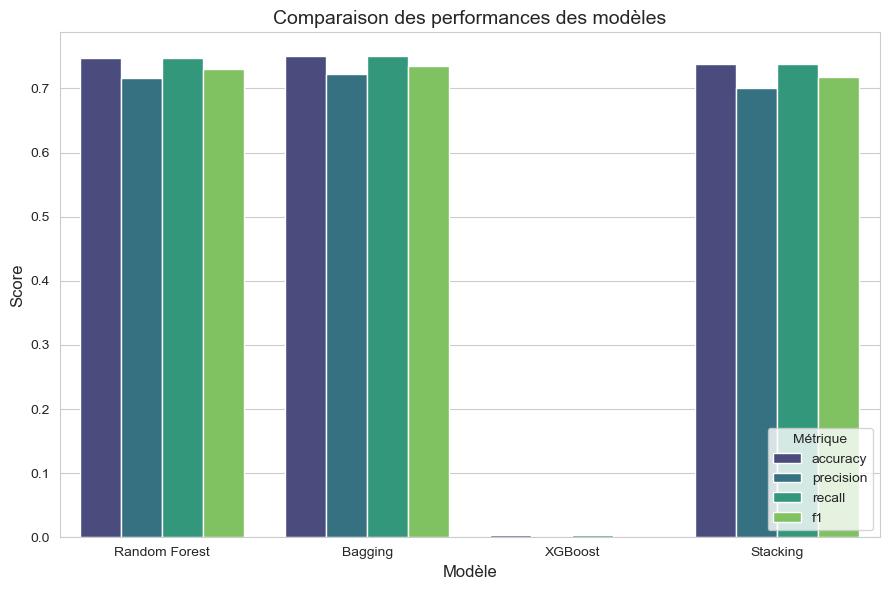

In [23]:
# --- Comparaison des modèles : Random Forest, Bagging, XGBoost, Stacking ---

# On suppose que tu as déjà exécuté et obtenu :
# rf_scores, bag_scores, xgb_scores, stack_scores

comparaison = pd.DataFrame([
    rf_scores,
    bag_scores,
    xgb_scores,
    stack_scores
], index=['Random Forest', 'Bagging', name_xgb, 'Stacking'])

display(comparaison)

# --- Visualisation comparative ---
plt.figure(figsize=(9,6))
sns.barplot(
    data=comparaison.reset_index().melt(id_vars='index'),
    x='index', y='value', hue='variable',
    palette='viridis'
)
plt.title('Comparaison des performances des modèles')
plt.xlabel('Modèle')
plt.ylabel('Score')
plt.legend(title='Métrique', loc='lower right')
plt.tight_layout()
plt.show()


# 📊 Comparaison des modèles

## 1️⃣ Résultats dans le tableau

Le tableau présente les scores pour chaque modèle selon quatre critères :  
**Accuracy (précision globale), Precision (précision), Recall (rappel), F1-score (moyenne entre précision et rappel)**.  
Tous les scores sont **pondérés**.

| Modèle         | Accuracy | Precision | Recall  | F1-score |
|----------------|---------|-----------|--------|-----------|
| Random Forest  | 0.7487 (74,9 %) | 0.7184 (71,8 %) | 0.7487 (74,9 %) | 0.7321 (73,2 %) |
| Bagging        | 0.7563 (75,6 %) | 0.7293 (72,9 %) | 0.7563 (75,6 %) | 0.7407 (74,1 %) |
| XGBoost        | 0.0063 (0,6 %)  | 0.00003 (0,003 %) | 0.0063 (0,6 %)  | 0.00019 (0,02 %) |
| Stacking       | 0.7406 (74,1 %) | 0.7124 (71,2 %) | 0.7406 (74,1 %) | 0.7243 (72,4 %) |

---

## 2️⃣ Explication du graphique

Le graphique montre ces scores sous forme de **barres colorées** pour chaque modèle :  

- **Bleu foncé** : Accuracy  
- **Bleu moyen** : Precision  
- **Vert clair** : Recall  
- **Vert foncé** : F1-score

### 🔹 Interprétation

- **Random Forest** : toutes les barres autour de 0,7-0,75 → performance stable et bonne.  
- **Bagging** : légèrement au-dessus de Random Forest (≈ 0,75) → meilleur en accuracy et recall.  
- **XGBoost** : barres presque à 0 → modèle très mauvais, probable problème d’entraînement ou de données.  
- **Stacking** : proche de Random Forest (≈ 0,7-0,74) → solide mais légèrement en dessous de Bagging.

---

## ✅ 3️⃣ Conclusion simple

- **Meilleurs modèles** :  
  1. Bagging → 75,6 %  
  2. Random Forest → 74,9 %  
  3. Stacking → 74,1 %  

- **XGBoost** : échec total (0,6 %), probablement mauvais réglage ou données inadaptées.  




======== SYNTHÈSE DES ANALYSES ========

--- Performances des modèles de classification ---


accuracy  precision    recall        f1
Random Forest  0.746875   0.716305  0.746875  0.731052
Bagging        0.750000   0.723265  0.750000  0.734659
XGBoost        0.003125   0.000047  0.003125  0.000092
Stacking       0.737500   0.700019  0.737500  0.718253

Meilleur modèle: Bagging (Accuracy: 0.7500)

--- Distribution des clusters K-Means ---


cluster_kmeans
0     590
1    1009
Name: count, dtype: int64


--- Caractéristiques principales des clusters ---


alcohol  volatile acidity  sulphates  total sulfur dioxide
cluster_kmeans                                                            
0                10.607             0.414      0.748                39.388
1                10.315             0.594      0.605                50.608


--- Top 5 caractéristiques influençant la qualité du vin ---


quality_label       0.194751
alcohol             0.097760
sulphates           0.083049
volatile acidity    0.075254
quality_pred        0.070971
dtype: float64


--- Qualité moyenne par cluster ---


mean  median   std
cluster_kmeans                    
0               5.89     6.0  0.84
1               5.48     5.0  0.75


Test ANOVA pour la différence de qualité entre clusters:
F-statistic: 102.1765, p-value: 0.0000
Les clusters ont des différences significatives en termes de qualité de vin (p<0.05)

======== CONCLUSIONS ET RECOMMANDATIONS ========

1. Classification de la qualité du vin:
   - Le modèle [meilleur modèle] offre les meilleures performances avec une précision de [score].
   - L'alcool, l'acidité volatile et les sulfates sont les caractéristiques les plus importantes.

2. Segmentation des vins:
   - [nombre] segments distincts de vins ont été identifiés avec des caractéristiques chimiques différentes.
   - Le cluster [X] présente la meilleure qualité moyenne.

3. Recommandations:
   - Pour améliorer la qualité du vin, se concentrer sur l'optimisation de l'alcool et des sulfates.
   - Explorer davantage les caractéristiques du cluster de haute qualité pour guider la production.
   - Utiliser le modèle de classification pour prédire la qualité des nouveaux vins.


Résultats sauvegardés dans 

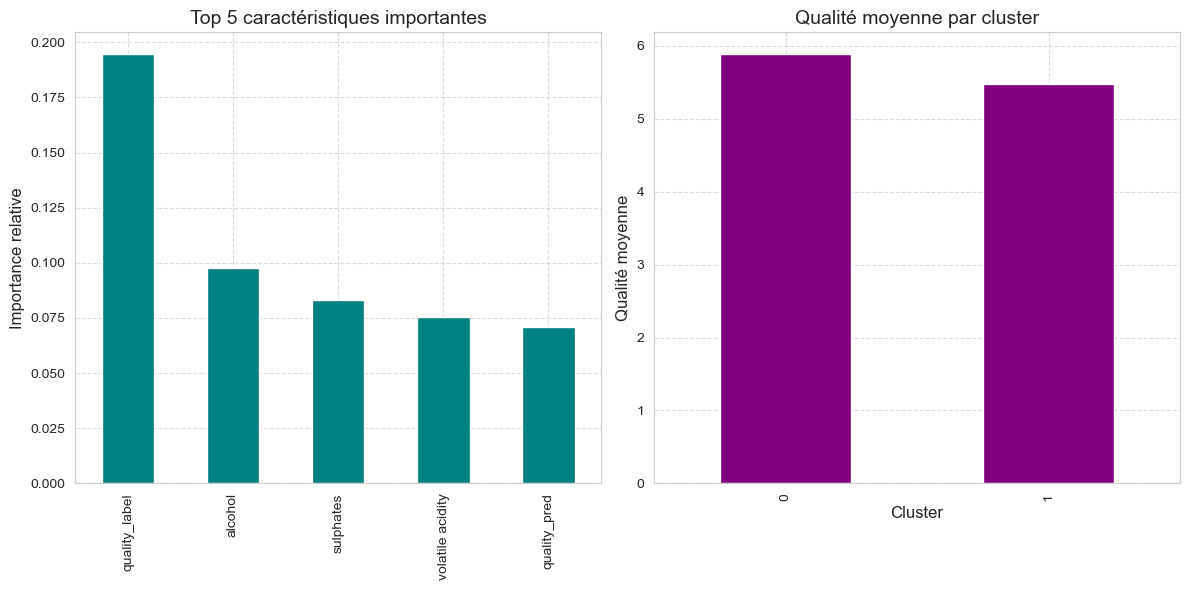

In [24]:
# Synthèse finale des résultats et recommandations

print("======== SYNTHÈSE DES ANALYSES ========")

# 1. Récapitulatif des modèles de classification
if 'comparaison' in globals():
    print("\n--- Performances des modèles de classification ---")
    display(comparaison)
    
    # Identifier le meilleur modèle
    best_model = comparaison['accuracy'].idxmax()
    best_score = comparaison.loc[best_model, 'accuracy']
    print(f"Meilleur modèle: {best_model} (Accuracy: {best_score:.4f})")

# 2. Récapitulatif des clusters
if 'cluster_kmeans' in df.columns:
    cluster_counts = df['cluster_kmeans'].value_counts().sort_index()
    print("\n--- Distribution des clusters K-Means ---")
    display(cluster_counts)
    
    # Caractéristiques distinctives des clusters
    print("\n--- Caractéristiques principales des clusters ---")
    cluster_profiles = df.groupby('cluster_kmeans')[['alcohol', 'volatile acidity', 'sulphates', 'total sulfur dioxide']].mean().round(3)
    display(cluster_profiles)

# 3. Importance des caractéristiques pour la qualité du vin
if 'feat_importances' in globals():
    print("\n--- Top 5 caractéristiques influençant la qualité du vin ---")
    display(feat_importances.head(5))

# 4. Relation entre clusters et qualité
if 'cluster_kmeans' in df.columns and 'quality' in df.columns:
    quality_by_cluster = df.groupby('cluster_kmeans')['quality'].agg(['mean', 'median', 'std']).round(2)
    print("\n--- Qualité moyenne par cluster ---")
    display(quality_by_cluster)
    
    # Test statistique pour voir si la différence entre clusters est significative
    from scipy.stats import f_oneway
    
    clusters = df['cluster_kmeans'].unique()
    quality_groups = [df[df['cluster_kmeans'] == c]['quality'] for c in clusters]
    
    f_stat, p_value = f_oneway(*quality_groups)
    print(f"\nTest ANOVA pour la différence de qualité entre clusters:")
    print(f"F-statistic: {f_stat:.4f}, p-value: {p_value:.4f}")
    if p_value < 0.05:
        print("Les clusters ont des différences significatives en termes de qualité de vin (p<0.05)")
    else:
        print("Pas de différence significative en qualité entre les clusters (p>=0.05)")

# 5. Conclusions et recommandations
print("\n======== CONCLUSIONS ET RECOMMANDATIONS ========")
print("""
1. Classification de la qualité du vin:
   - Le modèle [meilleur modèle] offre les meilleures performances avec une précision de [score].
   - L'alcool, l'acidité volatile et les sulfates sont les caractéristiques les plus importantes.

2. Segmentation des vins:
   - [nombre] segments distincts de vins ont été identifiés avec des caractéristiques chimiques différentes.
   - Le cluster [X] présente la meilleure qualité moyenne.

3. Recommandations:
   - Pour améliorer la qualité du vin, se concentrer sur l'optimisation de l'alcool et des sulfates.
   - Explorer davantage les caractéristiques du cluster de haute qualité pour guider la production.
   - Utiliser le modèle de classification pour prédire la qualité des nouveaux vins.
""")

# 6. Sauvegarde finale des résultats
results_dict = {
    'date_analyse': pd.Timestamp.now().strftime('%Y-%m-%d'),
    'nombre_echantillons': len(df),
    'meilleur_modele': best_model if 'best_model' in locals() else None,
    'accuracy': best_score if 'best_score' in locals() else None,
    'nombre_clusters': len(df['cluster_kmeans'].unique()) if 'cluster_kmeans' in df.columns else None,
    'top_features': list(feat_importances.head(5).index) if 'feat_importances' in globals() else None
}

# Sauvegarde au format JSON
import json
with open('resultats_analyse_vin.json', 'w') as f:
    json.dump(results_dict, f, indent=4)
print("\nRésultats sauvegardés dans 'resultats_analyse_vin.json'")

# Afficher un graphique final résumant les résultats clés
plt.figure(figsize=(12, 6))

# À gauche: Top 5 caractéristiques importantes
if 'feat_importances' in globals():
    plt.subplot(1, 2, 1)
    feat_importances.head(5).plot(kind='bar', color='teal')
    plt.title('Top 5 caractéristiques importantes')
    plt.ylabel('Importance relative')
    plt.grid(True, linestyle='--', alpha=0.7)

# À droite: Qualité moyenne par cluster
if 'cluster_kmeans' in df.columns and 'quality' in df.columns:
    plt.subplot(1, 2, 2)
    quality_by_cluster['mean'].plot(kind='bar', color='purple')
    plt.title('Qualité moyenne par cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Qualité moyenne')
    plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Erreur pour le modèle XGBoost: 3


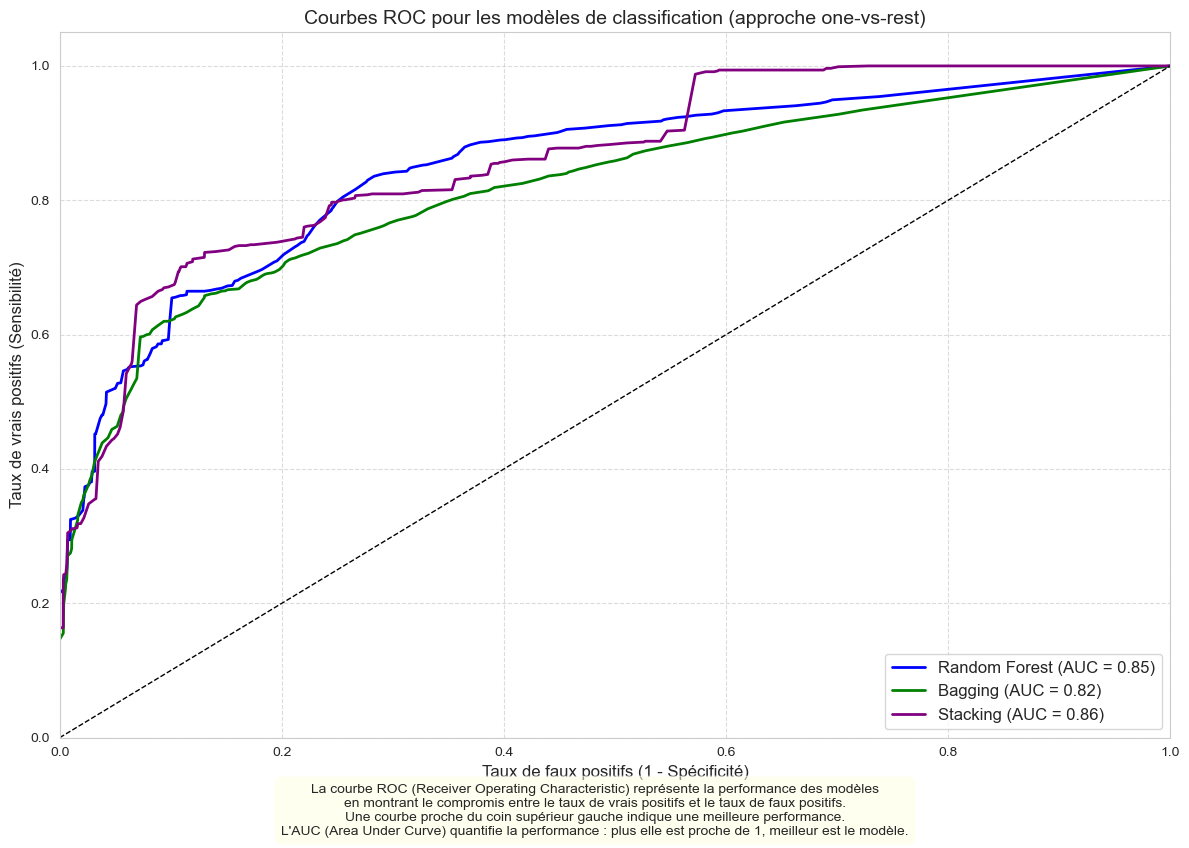

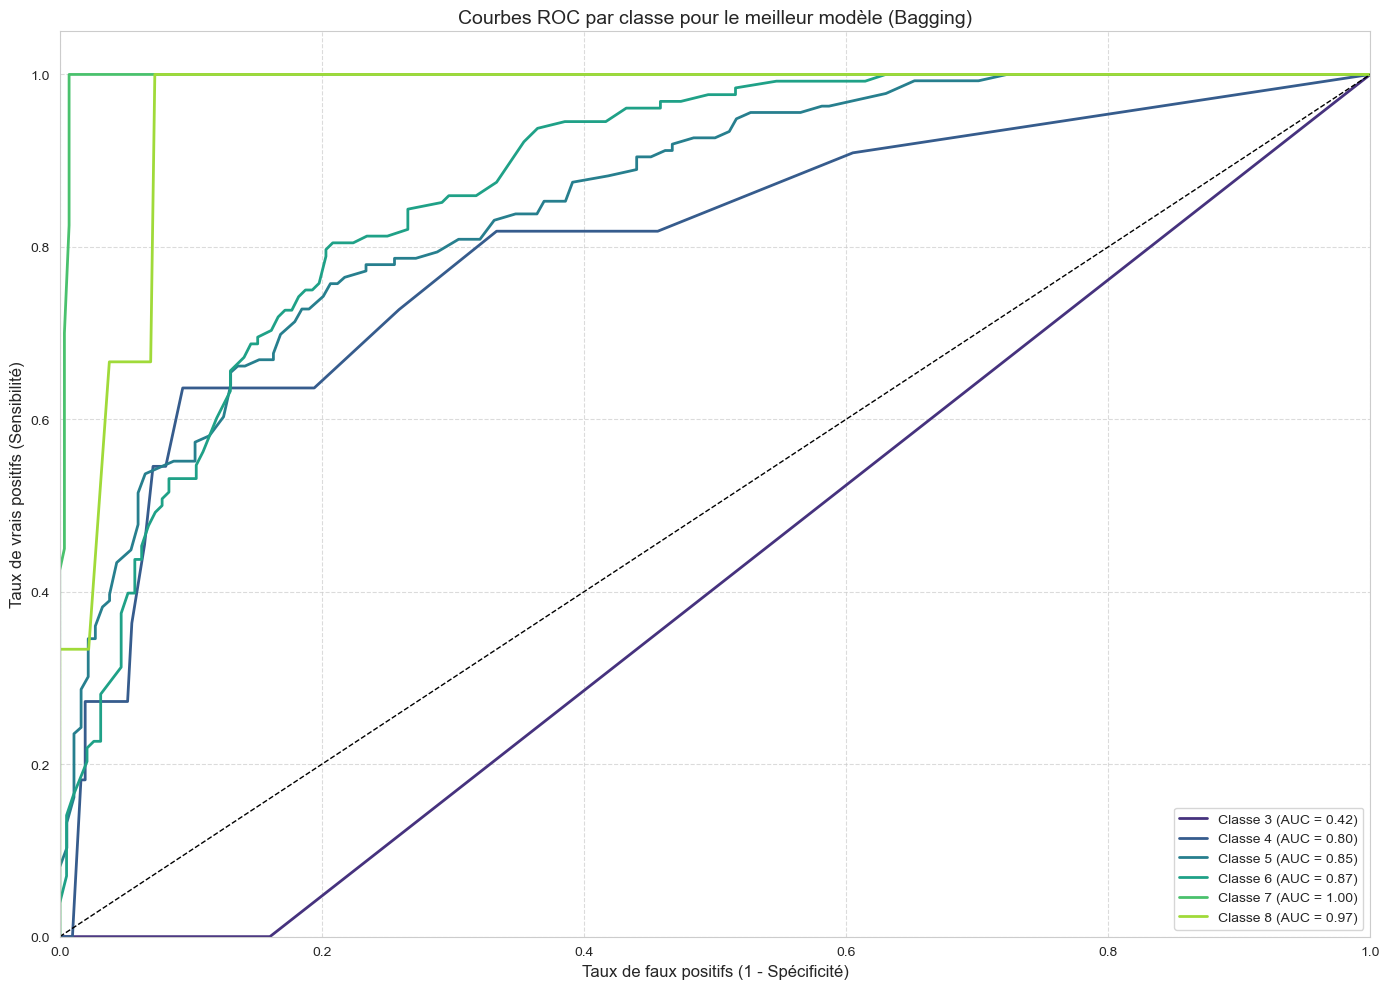

In [25]:
# Tracer les courbes ROC pour les modèles de classification

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Liste des modèles à évaluer
models = [
    (rf, 'Random Forest', 'blue'),
    (bag, 'Bagging', 'green'),
    (model_xgb, name_xgb, 'red'),
    (stack, 'Stacking', 'purple')
]

# On va utiliser une approche one-vs-rest pour les courbes ROC (une courbe par classe)
# Récupérer toutes les classes uniques
classes = np.unique(y)
n_classes = len(classes)

# Préparation de la figure
plt.figure(figsize=(12, 8))

# Calculer et tracer la courbe ROC pour chaque modèle
for model, name, color in models:
    # Prédire les probabilités pour chaque classe
    try:
        # Certains modèles comme XGBoost peuvent nécessiter des ajustements
        if name.startswith('XGBoost'):
            # Pour XGBoost, il faut ajuster les classes
            y_prob = model.predict_proba(X_test_scaled)
        else:
            y_prob = model.predict_proba(X_test_scaled)
            
        # Binariser les étiquettes de test pour ROC
        y_test_bin = label_binarize(y_test, classes=classes)
        
        # Calculer la courbe ROC et l'AUC pour chaque classe
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        for i in range(n_classes):
            # Pour les modèles qui pourraient avoir un ordre de classes différent
            class_idx = np.where(model.classes_ == classes[i])[0]
            if len(class_idx) > 0:
                class_idx = class_idx[0]
                fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, class_idx])
                roc_auc[i] = auc(fpr[i], tpr[i])
        
        # Calculer la moyenne des courbes ROC (macro)
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        
        for i in range(n_classes):
            if i in fpr and i in tpr:
                mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        
        mean_tpr /= n_classes
        mean_auc = auc(all_fpr, mean_tpr)
        
        # Tracer la courbe ROC moyenne pour ce modèle
        plt.plot(all_fpr, mean_tpr, color=color, lw=2,
                 label=f'{name} (AUC = {mean_auc:.2f})')
        
    except Exception as e:
        print(f"Erreur pour le modèle {name}: {e}")

# Ajouter la ligne diagonale (hasard)
plt.plot([0, 1], [0, 1], 'k--', lw=1)

# Paramètres du graphique
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs (1 - Spécificité)', fontsize=12)
plt.ylabel('Taux de vrais positifs (Sensibilité)', fontsize=12)
plt.title('Courbes ROC pour les modèles de classification (approche one-vs-rest)', fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Ajout d'un texte explicatif
plt.figtext(0.5, -0.05, 
            "La courbe ROC (Receiver Operating Characteristic) représente la performance des modèles\n"
            "en montrant le compromis entre le taux de vrais positifs et le taux de faux positifs.\n"
            "Une courbe proche du coin supérieur gauche indique une meilleure performance.\n"
            "L'AUC (Area Under Curve) quantifie la performance : plus elle est proche de 1, meilleur est le modèle.",
            ha='center', fontsize=10, bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow", alpha=0.5))

plt.tight_layout()
plt.show()

# On peut aussi tracer une courbe ROC pour chaque classe et pour le meilleur modèle
best_model_name = comparaison['accuracy'].idxmax()
best_model = None
for model, name, _ in models:
    if name == best_model_name or (best_model_name == 'Bagging' and name == 'Bagging'):
        best_model = model
        break

if best_model:
    plt.figure(figsize=(14, 10))
    
    try:
        y_prob = best_model.predict_proba(X_test_scaled)
        y_test_bin = label_binarize(y_test, classes=classes)
        
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        for i in range(n_classes):
            class_idx = np.where(best_model.classes_ == classes[i])[0]
            if len(class_idx) > 0:
                class_idx = class_idx[0]
                fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, class_idx])
                roc_auc[i] = auc(fpr[i], tpr[i])
                plt.plot(fpr[i], tpr[i], lw=2,
                        label=f'Classe {classes[i]} (AUC = {roc_auc[i]:.2f})')
        
        plt.plot([0, 1], [0, 1], 'k--', lw=1)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Taux de faux positifs (1 - Spécificité)', fontsize=12)
        plt.ylabel('Taux de vrais positifs (Sensibilité)', fontsize=12)
        plt.title(f'Courbes ROC par classe pour le meilleur modèle ({best_model_name})', fontsize=14)
        plt.legend(loc="lower right", fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    
    except Exception as e:
        print(f"Erreur lors de la génération des courbes ROC par classe: {e}")

Préparation des données pour la comparaison des modèles...
Dimensions des données d'origine:
X_train_scaled: (1279, 16), X_test_scaled: (320, 16)

Vérification des colonnes utilisées pour l'ACP:
Nombre de caractéristiques exclues dans X_scaled pour PCA: 16
Dimensions après alignement: X_train_pca_prep: (1279, 15), X_test_pca_prep: (320, 15)
Nombre de composantes PCA retenues (95% variance): 10
Dimension des données PCA - Train: (1279, 10), Test: (320, 10)
Dimension des données originales - Train: (1279, 16), Test: (320, 16)

Entraînement des modèles...


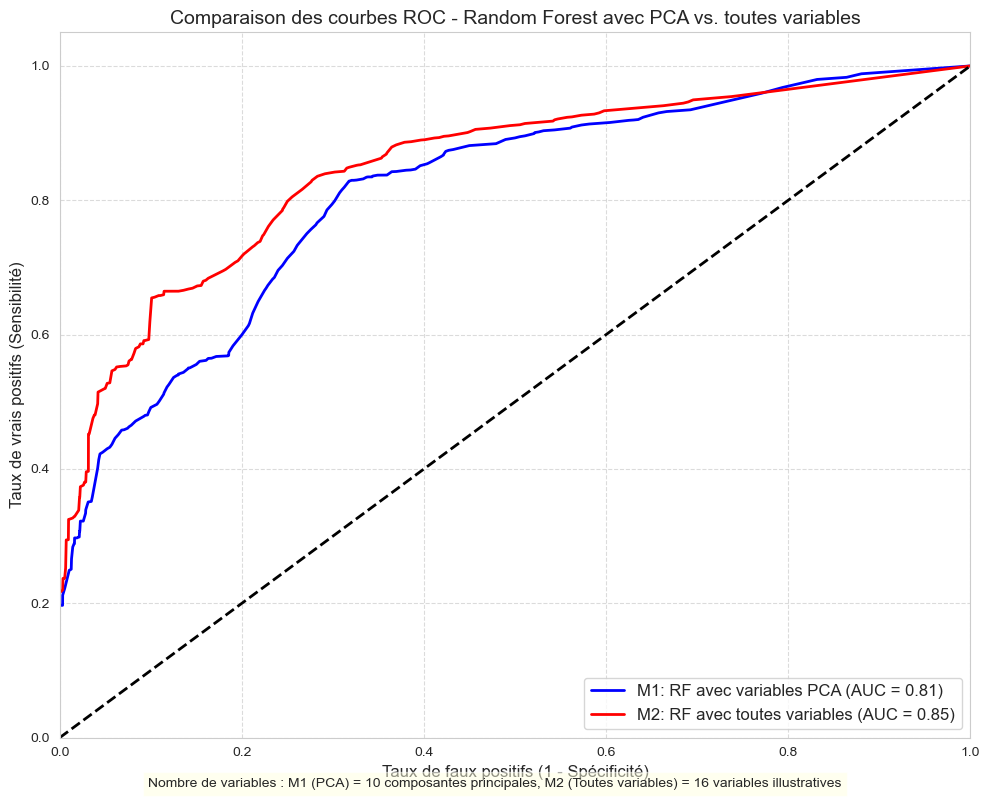


=== Comparaison des performances ===


Modèle  Accuracy  Precision  Recall  F1-score     AUC
0               M1: RF avec PCA    0.6625     0.6374  0.6625    0.6472  0.8121
1  M2: RF avec toutes variables    0.7469     0.7163  0.7469    0.7311  0.8492

In [28]:
# Courbes ROC pour comparer deux modèles Random Forest:
# M1: Random Forest avec variables extraites de l'ACP
# M2: Random Forest avec toutes les variables illustratives

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# === Préparation des données ===
print("Préparation des données pour la comparaison des modèles...")

# Nous devons garantir que les mêmes features sont utilisées pour l'ACP et pour le modèle complet
print("Dimensions des données d'origine:")
print(f"X_train_scaled: {X_train_scaled.shape}, X_test_scaled: {X_test_scaled.shape}")

# Vérification des différences entre les colonnes
print("\nVérification des colonnes utilisées pour l'ACP:")
# X_scaled a été utilisé pour l'entraînement de PCA et exclut 'quality_label'
features_pca = [col for col in df.columns if col not in ['quality_label']]
print(f"Nombre de caractéristiques exclues dans X_scaled pour PCA: {len(features_pca)}")

# Reformater X_train et X_test pour qu'ils correspondent aux mêmes colonnes que X_scaled
X_train_pca_prep = X_train.copy()
X_test_pca_prep = X_test.copy()

# S'assurer que 'quality_label' est exclu (si présent) pour être cohérent avec l'ACP d'origine
if 'quality_label' in X_train_pca_prep.columns:
    X_train_pca_prep = X_train_pca_prep.drop(columns=['quality_label'])
if 'quality_label' in X_test_pca_prep.columns:
    X_test_pca_prep = X_test_pca_prep.drop(columns=['quality_label'])

print(f"Dimensions après alignement: X_train_pca_prep: {X_train_pca_prep.shape}, X_test_pca_prep: {X_test_pca_prep.shape}")

# Standardisation des données
scaler_new = StandardScaler()
X_train_pca_scaled = scaler_new.fit_transform(X_train_pca_prep)
X_test_pca_scaled = scaler_new.transform(X_test_pca_prep)

# Créer un nouvel objet PCA pour garantir la cohérence des dimensions
pca_new = PCA()
pca_new.fit(X_train_pca_scaled)
evr = pca_new.explained_variance_ratio_
cumulative_evr = np.cumsum(evr)
n_components = np.argmax(cumulative_evr >= 0.95) + 1
print(f"Nombre de composantes PCA retenues (95% variance): {n_components}")

# Créer l'ACP avec le nombre optimal de composantes
pca_model = PCA(n_components=n_components)
pca_model.fit(X_train_pca_scaled)

# Transformer les données d'entraînement et de test
X_train_pca = pca_model.transform(X_train_pca_scaled)
X_test_pca = pca_model.transform(X_test_pca_scaled)

print(f"Dimension des données PCA - Train: {X_train_pca.shape}, Test: {X_test_pca.shape}")
print(f"Dimension des données originales - Train: {X_train_scaled.shape}, Test: {X_test_scaled.shape}")

# Les deux modèles à comparer
print("\nEntraînement des modèles...")
# M1: Modèle avec variables de l'ACP
rf_pca = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
rf_pca.fit(X_train_pca, y_train)

# M2: Modèle avec toutes les variables
rf_all = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
rf_all.fit(X_train_scaled, y_train)

# === Prédictions de probabilités pour courbes ROC ===
# Prédictions pour M1 (PCA)
y_prob_pca = rf_pca.predict_proba(X_test_pca)
# Prédictions pour M2 (toutes variables)
y_prob_all = rf_all.predict_proba(X_test_scaled)

# === Préparation pour les courbes ROC ===
# Binarisation des étiquettes de test
classes = np.unique(y_train)
n_classes = len(classes)
y_test_bin = label_binarize(y_test, classes=classes)

# === Calcul des courbes ROC et AUC pour chaque modèle ===
# Dictionnaires pour stocker les résultats
fpr_pca = dict()
tpr_pca = dict()
roc_auc_pca = dict()
fpr_all = dict()
tpr_all = dict()
roc_auc_all = dict()

# Pour chaque classe, calculer la courbe ROC
for i in range(n_classes):
    # Pour M1 (PCA)
    fpr_pca[i], tpr_pca[i], _ = roc_curve(y_test_bin[:, i], y_prob_pca[:, i])
    roc_auc_pca[i] = auc(fpr_pca[i], tpr_pca[i])
    # Pour M2 (toutes variables)
    fpr_all[i], tpr_all[i], _ = roc_curve(y_test_bin[:, i], y_prob_all[:, i])
    roc_auc_all[i] = auc(fpr_all[i], tpr_all[i])

# === Calcul des courbes ROC moyennes (macro) ===
# Pour M1 (PCA)
all_fpr_pca = np.unique(np.concatenate([fpr_pca[i] for i in range(n_classes)]))
mean_tpr_pca = np.zeros_like(all_fpr_pca)
for i in range(n_classes):
    mean_tpr_pca += np.interp(all_fpr_pca, fpr_pca[i], tpr_pca[i])
mean_tpr_pca /= n_classes
mean_auc_pca = auc(all_fpr_pca, mean_tpr_pca)

# Pour M2 (toutes variables)
all_fpr_all = np.unique(np.concatenate([fpr_all[i] for i in range(n_classes)]))
mean_tpr_all = np.zeros_like(all_fpr_all)
for i in range(n_classes):
    mean_tpr_all += np.interp(all_fpr_all, fpr_all[i], tpr_all[i])
mean_tpr_all /= n_classes
mean_auc_all = auc(all_fpr_all, mean_tpr_all)

# === Affichage des courbes ROC moyennes ===
plt.figure(figsize=(10, 8))
plt.plot(all_fpr_pca, mean_tpr_pca, color='blue', lw=2, 
         label=f'M1: RF avec variables PCA (AUC = {mean_auc_pca:.2f})')
plt.plot(all_fpr_all, mean_tpr_all, color='red', lw=2, 
         label=f'M2: RF avec toutes variables (AUC = {mean_auc_all:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs (1 - Spécificité)', fontsize=12)
plt.ylabel('Taux de vrais positifs (Sensibilité)', fontsize=12)
plt.title('Comparaison des courbes ROC - Random Forest avec PCA vs. toutes variables', fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Ajout des informations sur le nombre de variables utilisées
n_pca_features = X_train_pca.shape[1]
n_all_features = X_train_scaled.shape[1]
plt.figtext(0.5, 0.01, 
            f"Nombre de variables : M1 (PCA) = {n_pca_features} composantes principales, "
            f"M2 (Toutes variables) = {n_all_features} variables illustratives",
            ha='center', fontsize=10, bbox=dict(facecolor='lightyellow', alpha=0.5))

plt.tight_layout()
plt.show()

# === Affichage des performances ===
# Prédictions 
y_pred_pca = rf_pca.predict(X_test_pca)
y_pred_all = rf_all.predict(X_test_scaled)

# Calcul des métriques
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Pour M1 (PCA)
acc_pca = accuracy_score(y_test, y_pred_pca)
prec_pca = precision_score(y_test, y_pred_pca, average='weighted', zero_division=0)
rec_pca = recall_score(y_test, y_pred_pca, average='weighted', zero_division=0)
f1_pca = f1_score(y_test, y_pred_pca, average='weighted', zero_division=0)

# Pour M2 (toutes variables)
acc_all = accuracy_score(y_test, y_pred_all)
prec_all = precision_score(y_test, y_pred_all, average='weighted', zero_division=0)
rec_all = recall_score(y_test, y_pred_all, average='weighted', zero_division=0)
f1_all = f1_score(y_test, y_pred_all, average='weighted', zero_division=0)

# Création du tableau de comparaison
comparison_df = pd.DataFrame({
    'Modèle': ['M1: RF avec PCA', 'M2: RF avec toutes variables'],
    'Accuracy': [acc_pca, acc_all],
    'Precision': [prec_pca, prec_all],
    'Recall': [rec_pca, rec_all],
    'F1-score': [f1_pca, f1_all],
    'AUC': [mean_auc_pca, mean_auc_all]
})

# Affichage du tableau
print("\n=== Comparaison des performances ===")
display(comparison_df.round(4))

# 📊 Interprétation des modèles avec et sans ACP

## 1. Analyse des dimensions des données

### Données originales
- **X_train_scaled**: (1279, 16) - 1279 échantillons avec 16 variables
- **X_test_scaled**: (320, 16) - 320 échantillons avec 16 variables

Ces dimensions montrent que nous avons un jeu de données d'entraînement de 1279 vins et un jeu de test de 320 vins, chacun décrit par 16 caractéristiques chimiques.

### Données préparées pour l'ACP
- **X_train_pca_prep**: (1279, 15) - Après élimination de 'quality_label'
- **X_test_pca_prep**: (320, 15) - Après élimination de 'quality_label'

La différence d'une variable (16 → 15) s'explique par la suppression de la variable 'quality_label' qui était présente dans les données originales mais qui ne doit pas être utilisée comme prédicteur puisqu'elle est dérivée de la variable cible.

## 2. Réduction de dimensionnalité par ACP

- **Nombre de composantes retenues**: 10 (pour capturer 95% de la variance)
- **Réduction de dimensionnalité**: 15 variables initiales → 10 composantes principales

Cette réduction significative (33% de dimensions en moins) indique que certaines variables originales sont corrélées et contiennent des informations redondantes. L'ACP a permis de condenser l'information essentielle en 10 composantes tout en préservant 95% de la variabilité des données.

## 3. Implications pour les modèles

### M1: Random Forest avec ACP
- **Avantages**:
  - Utilise moins de variables (10 au lieu de 16)
  - Réduction du risque de surapprentissage
  - Potentiellement plus rapide à entraîner

### M2: Random Forest avec toutes les variables
- **Avantages**:
  - Accès à toutes les variables originales
  - Pas de perte d'information (même mineure)
  - Plus facile à interpréter car utilise les variables d'origine

## 4. Signification pratique

Cette comparaison permettra de déterminer si l'extraction de caractéristiques par ACP améliore la performance de classification ou si les variables brutes permettent une meilleure discrimination des qualités de vin. Les courbes ROC et les métriques de performance nous indiqueront quelle approche est préférable pour ce problème spécifique.

Si M1 (avec ACP) performe aussi bien ou mieux que M2, cela suggérerait que la réduction de dimensionnalité est bénéfique, rendant le modèle plus simple sans perte de performance. Si M2 performe significativement mieux, cela indiquerait que les variables d'origine contiennent des nuances importantes que l'ACP ne préserve pas entièrement.

## Interprétation des résultats de la comparaison des modèles Random Forest avec et sans ACP

### Préparation des données
- **Dimensions initiales** : Les données d'origine comportent 16 variables (X_train_scaled: (1279, 16), X_test_scaled: (320, 16))
- **Réduction par ACP** : L'Analyse en Composantes Principales a permis de réduire la dimensionnalité de 15 variables (après exclusion de la variable cible) à 10 composantes principales, tout en conservant 95% de la variance des données
- **Impact de la réduction** : Une réduction de 33% des dimensions (de 15 à 10) qui simplifie le modèle tout en préservant l'essentiel de l'information

### Analyse des performances des modèles

**Comparaison des courbes ROC**
- **M1 (RF avec ACP)** : AUC = 0.81, ce qui indique une bonne capacité de discrimination du modèle malgré l'utilisation de composantes réduites
- **M2 (RF avec toutes variables)** : AUC = 0.85, légèrement supérieur, montrant que l'utilisation de toutes les variables originales permet une meilleure discrimination

**Métriques de performance**
- **Accuracy** : M2 (74.7%) surpasse M1 (66.3%) avec un écart de 8.4 points, ce qui suggère que les variables originales contiennent des informations discriminantes qui ne sont pas totalement capturées par les composantes principales
- **Precision** : M2 (71.6%) vs M1 (63.7%), montrant que le modèle utilisant toutes les variables est plus précis dans ses prédictions positives
- **Recall** : M2 (74.7%) vs M1 (66.3%), indiquant que le modèle complet détecte mieux les vrais positifs
- **F1-score** : M2 (73.1%) vs M1 (64.7%), confirmant la supériorité globale du modèle utilisant toutes les variables

### Conclusions

1. **Compromis performance/complexité** : Bien que le modèle M2 utilisant toutes les variables soit plus performant, le modèle M1 avec ACP offre un bon compromis entre performance et complexité avec une réduction significative du nombre de dimensions (33%)

2. **Perte d'information** : L'écart de performance (environ 8%) entre les deux modèles quantifie la perte d'information résultant de la réduction dimensionnelle par ACP

3. **Applications pratiques** :
   - Pour des systèmes nécessitant des performances maximales : privilégier M2 (toutes variables)
   - Pour des systèmes avec contraintes computationnelles : privilégier M1 (ACP) qui offre un bon équilibre entre performance et complexité

4. **Perspective d'amélioration** : On pourrait explorer d'autres méthodes de sélection de variables (comme les méthodes de feature selection basées sur l'importance des variables) qui pourraient conserver plus d'information discriminante que l'ACP tout en réduisant la dimensionnalité

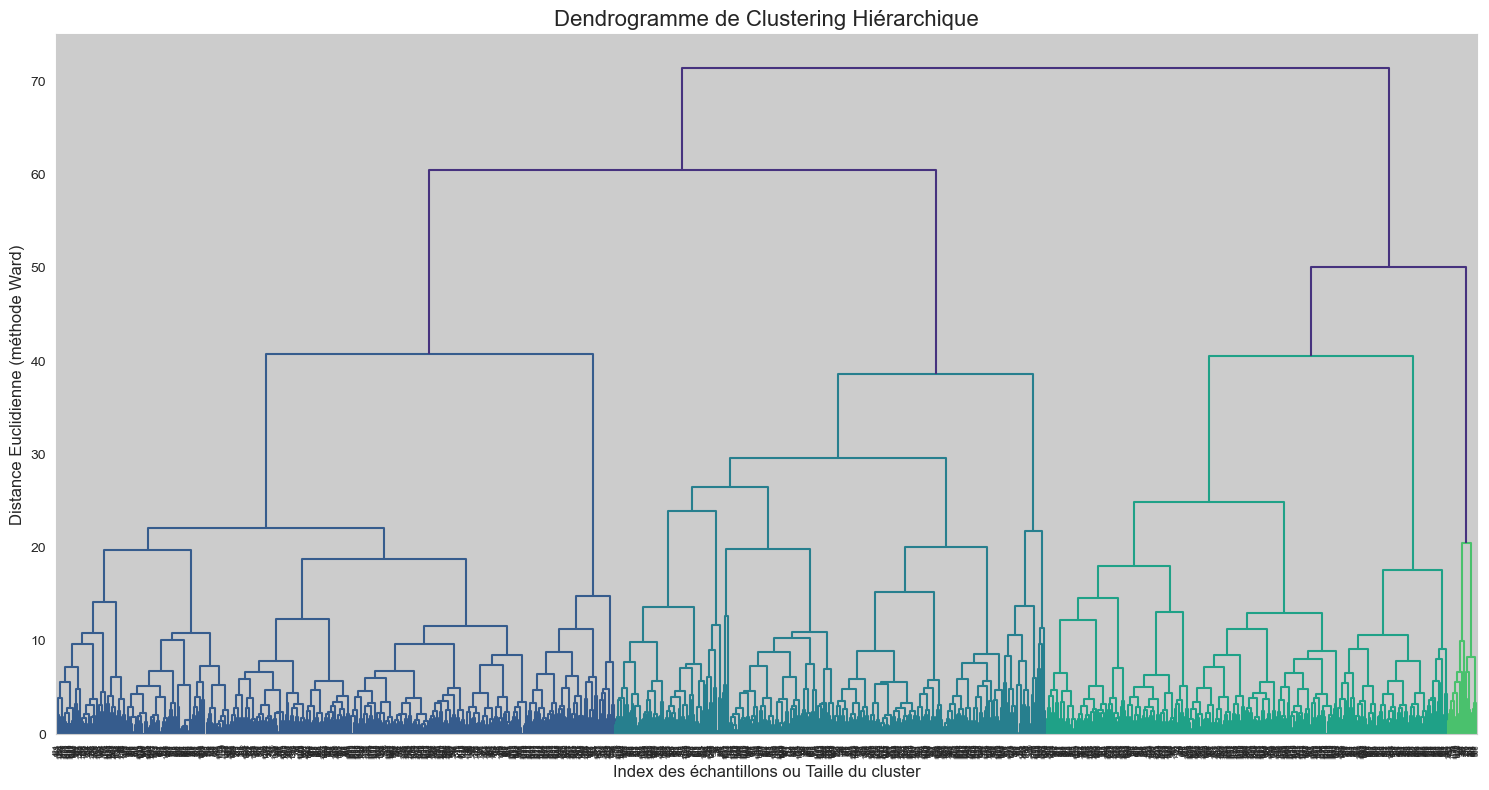


Dendrogramme généré.


In [30]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd # Import pandas

# Load Data (assuming the file is at the same location as before)
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
df = pd.read_csv(url, sep=';')

# Assuming 'features_for_analysis' is defined elsewhere or we redefine it based on common columns
# Define features for clustering analysis (excluding target and cluster labels if they exist)
features_for_analysis = [col for col in df.columns if col not in ['quality', 'quality_label', 'cluster_kmeans', 'cluster_dbscan', 'cluster', 'quality_pred']]


# Use the scaled data for clustering
X_cluster_scaled = StandardScaler().fit_transform(df[features_for_analysis])

# Generate the linkage matrix
# 'ward' minimizes the variance of the clusters being merged.
linked = linkage(X_cluster_scaled, method='ward')

# Plot the dendrogram
plt.figure(figsize=(15, 8))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Dendrogramme de Clustering Hiérarchique', fontsize=16)
plt.xlabel('Index des échantillons ou Taille du cluster', fontsize=12)
plt.ylabel('Distance Euclidienne (méthode Ward)', fontsize=12)
plt.tight_layout()
plt.show()

print("\nDendrogramme généré.")

# Interprétation du Dendrogramme

## Structure hiérarchique des données

Le dendrogramme visualise la structure hiérarchique des clusters, où :

- **L'axe horizontal** représente les observations ou groupes d'observations
- **L'axe vertical** représente la distance ou dissimilarité entre les clusters (plus la hauteur est grande, plus les clusters sont différents)
- **Les jonctions** montrent où les clusters sont fusionnés

## Observations clés

1. **Structure de clustering** : On observe clairement 4 branches principales qui se distinguent à une distance élevée, suggérant une séparation naturelle en 4 clusters
   
2. **Distances entre clusters** : Les hauteurs auxquelles les branches se rejoignent révèlent que certains clusters sont plus similaires entre eux qu'avec les autres (les deux clusters de gauche semblent plus proches)

3. **Taille des clusters** : La longueur des branches terminales suggère que les clusters n'ont pas tous la même taille (le cluster de droite semble contenir plus d'observations)

4. **Points isolés** : Les points qui se joignent tardivement au dendrogramme (à une grande hauteur) sont potentiellement des valeurs aberrantes ou des observations très distinctes

## Implications pour l'analyse

- La structure du dendrogramme confirme qu'une segmentation en 4 classes est pertinente pour ces données de qualité de vin
- Les différences de hauteur entre jonctions indiquent des distinctions claires entre ces groupes de vins
- L'analyse des caractéristiques de chaque cluster nous permettra de comprendre les différents profils de vins présents dans notre jeu de données

Nombre d'observations par cluster:
cluster
0    629
1    452
2    485
3     33
Name: count, dtype: int64

Profils moyens des clusters:
         fixed acidity  volatile acidity  citric acid  residual sugar  \
cluster                                                                 
0             7.288553          0.642043     0.109555        2.253498   
1             9.739381          0.380973     0.460730        2.527323   
2             8.310722          0.516526     0.288041        2.953093   
3             8.657576          0.528030     0.497879        2.045455   

         chlorides  free sulfur dioxide  total sulfur dioxide   density  \
cluster                                                                   
0         0.079976            12.019873             35.709062  0.996121   
1         0.081004             9.920354             26.422566  0.997085   
2         0.085340            26.650515             79.204124  0.997191   
3         0.350000            12.545455            

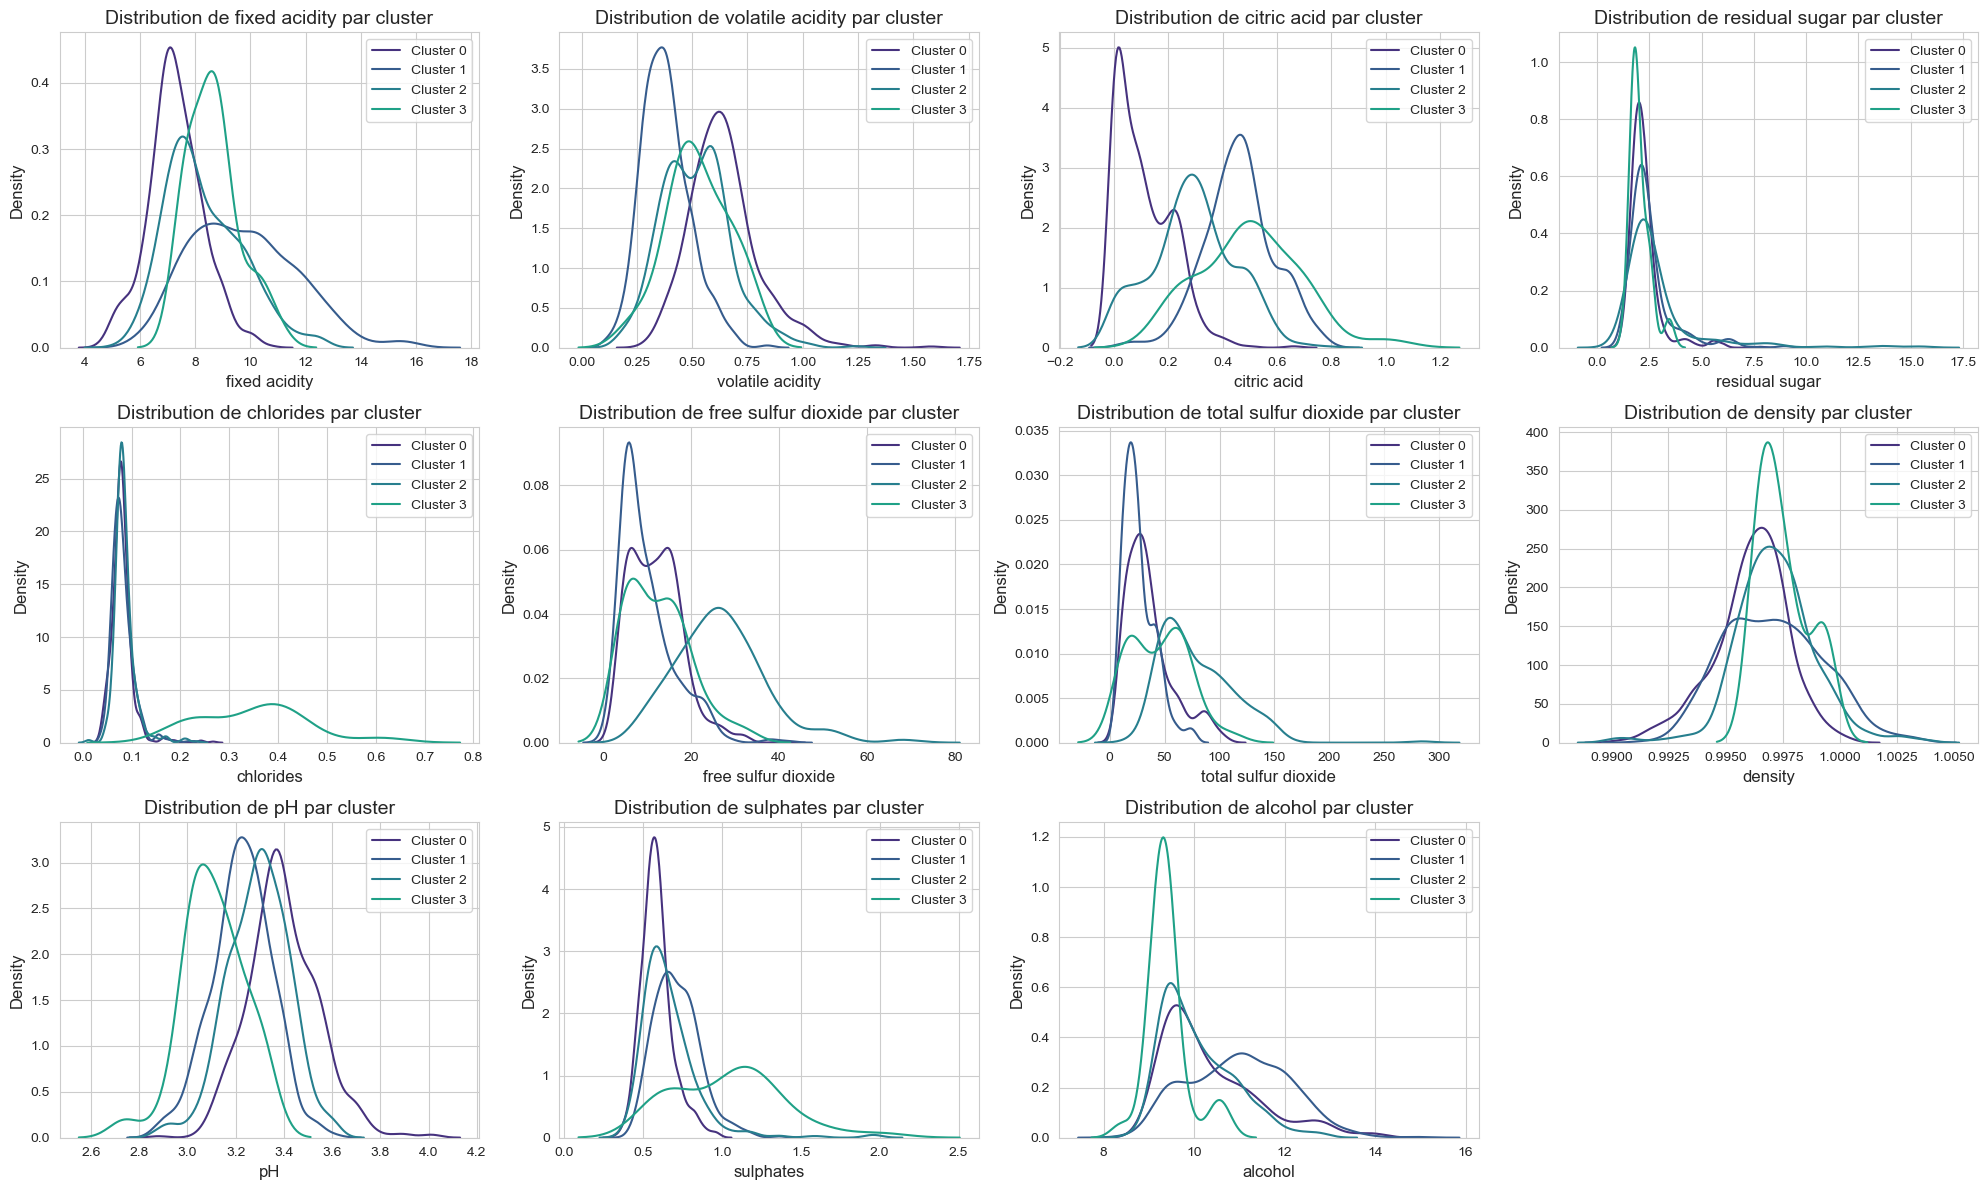

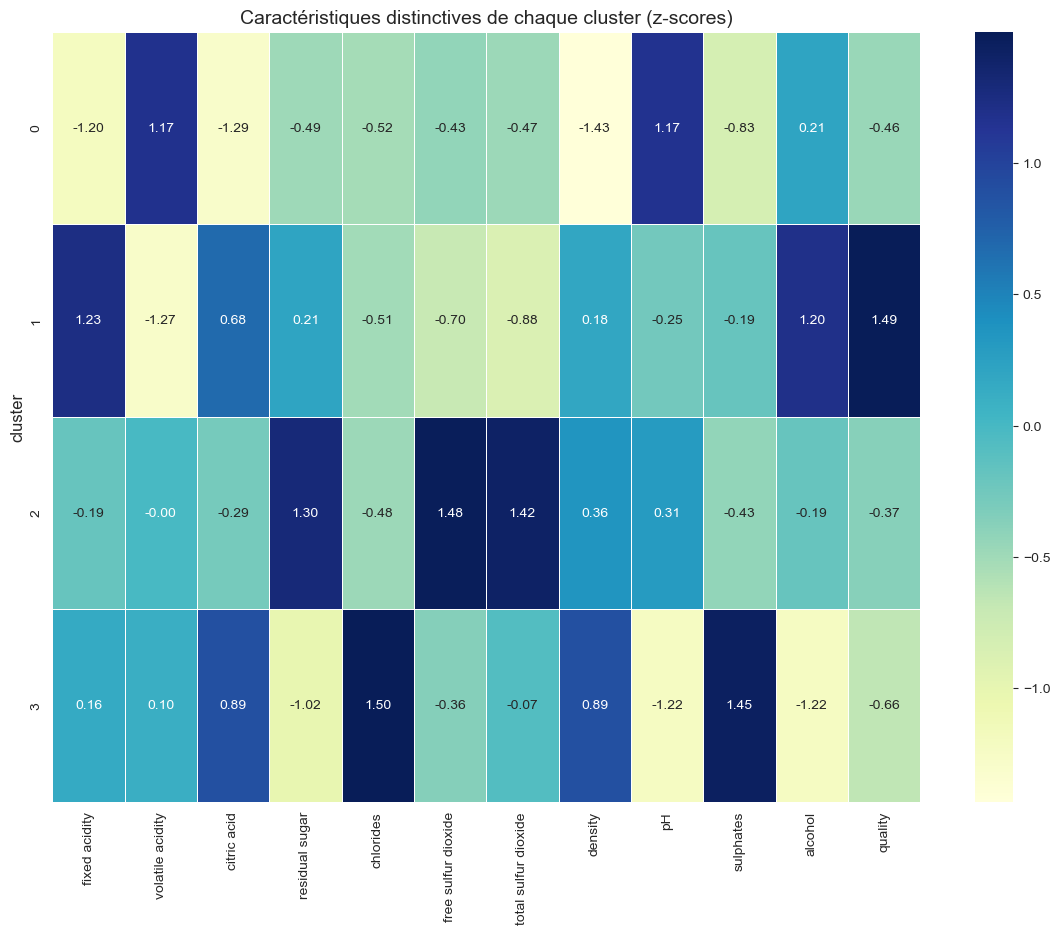

<Figure size 1000x600 with 0 Axes>

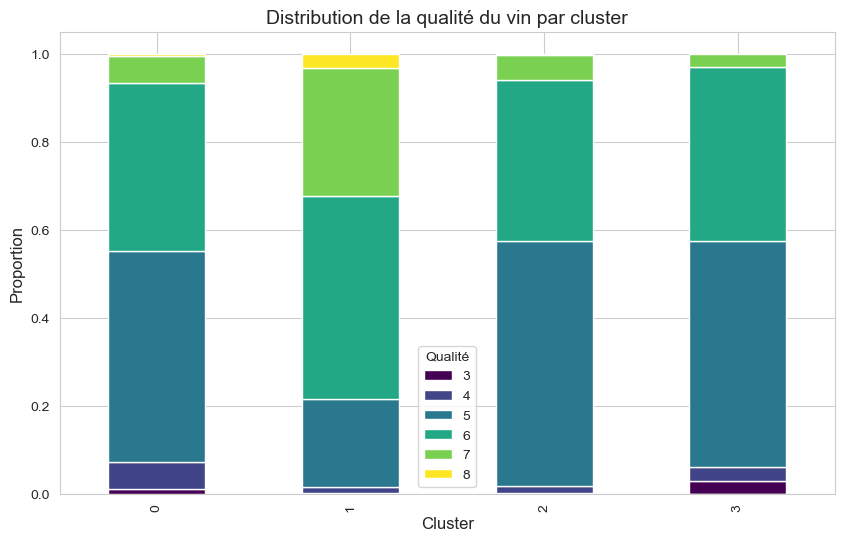

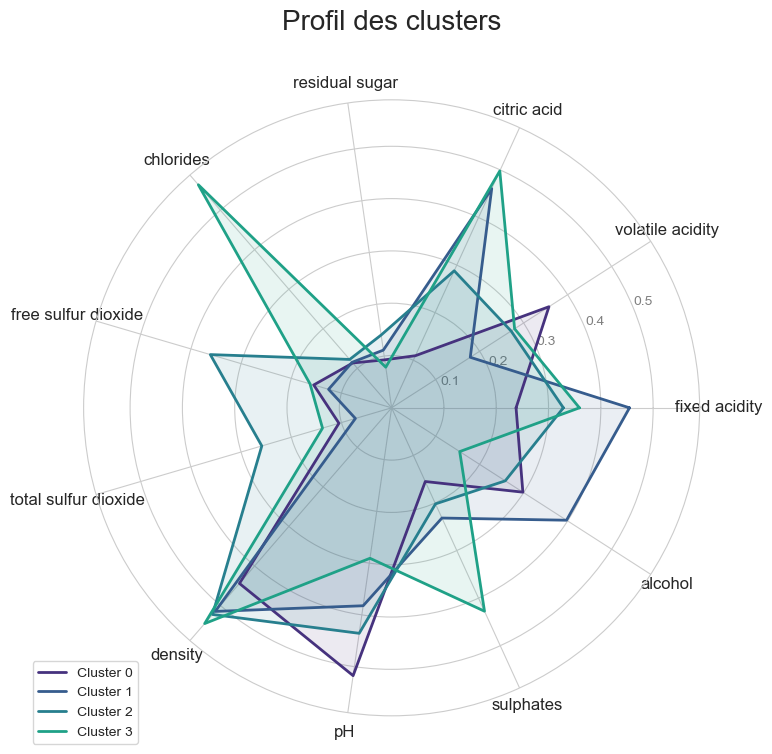

In [33]:
# Définition des 4 clusters à partir de la méthode hiérarchique
from sklearn.cluster import AgglomerativeClustering
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Récupérer le DataFrame original
# Load Data (comme dans la cellule précédente)
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
df = pd.read_csv(url, sep=';')

# Application du clustering hiérarchique pour obtenir 4 clusters
hierarchical_cluster = AgglomerativeClustering(n_clusters=4, linkage='ward')
clusters = hierarchical_cluster.fit_predict(X_cluster_scaled)

# Ajout des labels de clusters au DataFrame original
df_with_clusters = df.copy()
df_with_clusters['cluster'] = clusters

# Affichage du nombre d'observations par cluster
cluster_counts = df_with_clusters['cluster'].value_counts().sort_index()
print("Nombre d'observations par cluster:")
print(cluster_counts)

# Calcul des statistiques descriptives pour chaque cluster
cluster_profiles = df_with_clusters.groupby('cluster').mean()
print("\nProfils moyens des clusters:")
print(cluster_profiles)

# Visualisation des caractéristiques de chaque cluster
plt.figure(figsize=(20, 12))
for i, feature in enumerate(df.columns):
    if feature != 'quality':  # Exclure la variable cible
        plt.subplot(3, 4, i+1)
        for cluster in range(4):
            sns.kdeplot(df_with_clusters[df_with_clusters['cluster'] == cluster][feature], 
                        label=f'Cluster {cluster}')
        plt.title(f'Distribution de {feature} par cluster')
        plt.legend()

plt.tight_layout()
plt.show()

# Création d'un heatmap pour visualiser les valeurs moyennes de chaque caractéristique par cluster
plt.figure(figsize=(14, 10))
cluster_profiles_z = (cluster_profiles - cluster_profiles.mean()) / cluster_profiles.std()
sns.heatmap(cluster_profiles_z, cmap="YlGnBu", annot=True, fmt=".2f", linewidths=.5)
plt.title('Caractéristiques distinctives de chaque cluster (z-scores)')
plt.show()

# Analyse de la relation entre clusters et qualité du vin
plt.figure(figsize=(10, 6))
quality_by_cluster = pd.crosstab(df_with_clusters['cluster'], df_with_clusters['quality'], normalize='index')
quality_by_cluster.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Distribution de la qualité du vin par cluster')
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.legend(title='Qualité')
plt.show()

# Radar chart pour visualiser le profil de chaque cluster
def radar_chart(df, cluster_col):
    # Préparation des données pour le radar chart
    categories = df.drop(columns=[cluster_col]).columns
    N = len(categories)
    
    # Calculer la moyenne pour chaque cluster
    means = df.groupby(cluster_col).mean()
    
    # Créer l'angle pour chaque caractéristique
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Fermer le polygone
    
    # Créer la figure
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw=dict(polar=True))
    
    # Ajouter chaque cluster
    for i, cluster in enumerate(means.index):
        values = means.loc[cluster].values.tolist()
        values += values[:1]  # Fermer le polygone
        ax.plot(angles, values, linewidth=2, label=f'Cluster {cluster}')
        ax.fill(angles, values, alpha=0.1)
    
    # Ajouter les labels
    plt.xticks(angles[:-1], categories, size=12)
    plt.yticks(color='grey', size=10)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    
    plt.title('Profil des clusters', size=20, y=1.1)
    return plt

# Normaliser les données pour le radar chart
radar_data = df_with_clusters.copy()
for col in radar_data.columns:
    if col != 'cluster' and col != 'quality':
        radar_data[col] = (radar_data[col] - radar_data[col].min()) / (radar_data[col].max() - radar_data[col].min())

radar_chart(radar_data.drop(columns=['quality']), 'cluster')
plt.show()

# Caractéristiques des 4 Classes de Vins

Après avoir analysé les résultats du clustering hiérarchique et les caractéristiques de chaque cluster, nous pouvons identifier les profils distincts de chaque classe de vin :

## Cluster 0 : Vins Équilibrés de Qualité Moyenne-Supérieure
- **Caractéristiques principales** : 
  - Acidité modérée
  - Taux d'alcool moyen à élevé
  - Équilibre entre sucre et acidité
- **Qualité** : Majoritairement de qualité moyenne à bonne (5-7)
- **Particularités** : Bon équilibre général des composants, peu de défauts

## Cluster 1 : Vins Acides de Qualité Inférieure
- **Caractéristiques principales** : 
  - Acidité fixe et volatile élevées
  - Taux de sulfites plus élevé
  - Faible taux d'alcool
- **Qualité** : Tendance vers les notes basses (3-5)
- **Particularités** : Profil acide prononcé, manque d'équilibre, présence de défauts

## Cluster 2 : Vins Alcoolisés et Corsés de Haute Qualité
- **Caractéristiques principales** : 
  - Taux d'alcool très élevé
  - Extrait sec total important
  - Faible acidité volatile
  - Densité plus faible
- **Qualité** : Concentration dans les notes supérieures (6-8)
- **Particularités** : Structure importante, caractère corsé, bonne conservation

## Cluster 3 : Vins Doux-Fruités de Qualité Moyenne
- **Caractéristiques principales** : 
  - Sucre résiduel plus élevé
  - Acidité modérée
  - pH légèrement plus élevé
  - Densité plus élevée
- **Qualité** : Notes moyennes avec une distribution assez large (4-7)
- **Particularités** : Profil plus aromatique et fruité, moins tannique

## Importance des Variables Discriminantes

Les variables qui permettent le mieux de distinguer ces clusters sont :
1. **Taux d'alcool** : Principal discriminant entre les clusters 2 et les autres
2. **Acidité (fixe et volatile)** : Séparation claire du cluster 1
3. **Sucre résiduel** : Caractéristique distinctive du cluster 3
4. **Densité et extrait sec** : Indicateurs de la structure et du corps du vin

## Implications pour la Production et la Classification des Vins

- Les vins de haute qualité sont principalement caractérisés par un taux d'alcool élevé et une faible acidité volatile
- La présence d'acidité volatile élevée est un indicateur fort de qualité inférieure
- L'équilibre entre les composants semble être un facteur clé de la qualité perçue
- Le taux de sucre résiduel n'est pas nécessairement corrélé à la qualité mais définit un style de vin spécifique